# The Asteroseismic Imprints of Mass Transfer
by [Tom Wagg](https://tomwagg.com)$^{1}$

$^1$[]()_Department of Astronomy, University of Washington, Seattle, WA, USA_

This notebook reproduces the figures and results from our paper.

In [1]:
import os

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.visualization import quantity_support
quantity_support()

import seaborn as sns
import h5py as h5

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [3]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mpt

In [4]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [5]:
tracks = {}
folders_labels = [(f"D_{min_D_mix}", f"min_D_mix = {min_D_mix}") for min_D_mix in [1, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]]
folders_labels.append(("D_20_no_detach", "min_D_mix = 20, no detachment"))
folders_labels.append(("convergence-mesh_0.2-time_0.5", "Convergence test"))
for folder, label in folders_labels:
    path = os.path.join("../output/binaries", folder)
    tracks[folder] = [mesagrid.Track(path, dir_name="LOGS_star1", parameters=f"{label} (Donor)"),
                      mesagrid.Track(path, dir_name="LOGS_star2", parameters=f"{label} (Accretor)")]

In [6]:
singles = {
    "D_20": {},
    "D_100": {},
    "D_20_until_he4": {},
}
Ms = np.arange(3.0, 6.1, 0.1)
for folder in singles:
    for M in Ms:
        subfolder = f"M_{M:1.1f}"
        singles[folder][subfolder] = mesagrid.Track(dir=f"../output/singles/{folder}/{subfolder}",
                                                    parameters=f'{subfolder} ({folder})')

# Binary Evolution

We can first consider how our simulated binary evolves and compare it to an equivalent single star.

## HR Diagram

In [7]:
x = [(mpt.get_hr_position(tracks["D_20_no_detach"][0], "zams"), (0.05, 0.07), 'D1'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "mt_start"), (-0.05, 0.07), 'D2'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "closest_approach"), (-0.04, -0.08), 'D3'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "mt_end"), (0.02, -0.1), 'D4'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "cheb"), (0.02, -0.1), 'D5'),
                      (mpt.get_hr_position(tracks["D_20"][1], "zams"), (0.05, 0.07), 'A1'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_start"), (-0.04, -0.08), 'A2'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_end"), (0.01, 0.1), 'A3'),
                      (mpt.get_hr_position(tracks["D_20"][1], "cheb"), (-0.05, 0.02), 'A4')]

Parsing min_D_mix = 20, no detachment (Donor)
Parsing min_D_mix = 20 (Accretor)


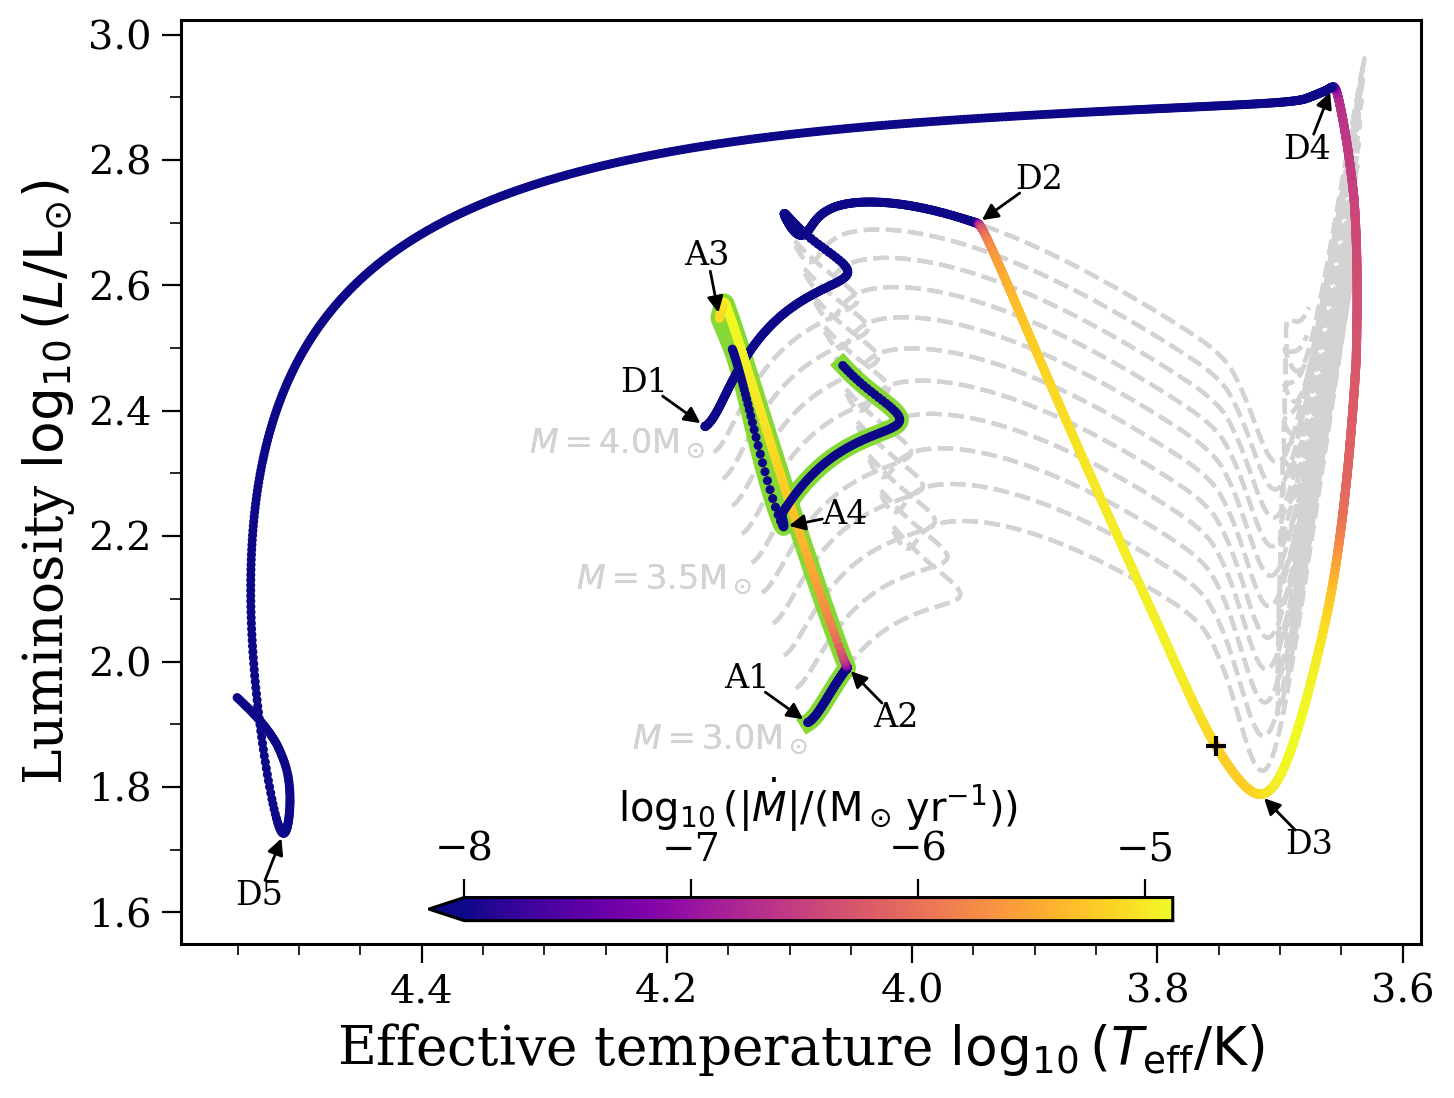

In [18]:
refresh_mpt()
fig, ax = None, None

fig, ax = mpt.simple_hr(tracks["D_20_no_detach"][0], fig=fig, ax=ax, show=False, s=0,
                        cbar_var="log_abs_mdot", cmap="plasma",
                        cbar_label=r"$\log_{10} (|\dot{M}| / ({\rm M_\odot \, yr^{-1}}))$",
                        cbar_loc=[0.2, 0.025, 0.6, 0.025],
                        vmin=-8, inset_cbar=True, rasterized=True)

for track, cmap, cutter in zip([tracks["D_20"][0], tracks["D_20_no_detach"][0], tracks["D_20"][1]], ["plasma", "plasma", "plasma"], [False, False, False]):
    mod_range, time_step = None, None
    if cutter:
        df = tracks["D_20"][0].history
        df = df.loc[df["log_abs_mdot"] > -8]
        df = df.loc[df["log_L"] == df["log_L"].min()]
        mod_range = [df.index[0], np.inf]
        time_step = 1e-1
    fig, ax = mpt.simple_hr(track, fig=fig, ax=ax, show=False, s=5 if not cutter else 0, cmap=cmap,
                            cbar_var="log_abs_mdot",
                            cbar_label=r"$\log_{10} (|\dot{M}| / ({\rm M_\odot \, yr^{-1}}))$",
                            cbar_loc=[0.2, 0.025, 0.6, 0.025], plot_line=not cutter,
                            vmin=-8, inset_cbar=True, rasterized=True, mod_range=mod_range, time_step=time_step)
    fig, ax = mpt.add_singles_tracks(fig, ax, singles["D_20_until_he4"], Ms=np.arange(3.0, 4.1, 0.1), linestyle="--")
ax.set_ylim(bottom=1.55)

ax.scatter(tracks["D_20"][0].history["log_Teff"].iloc[-1], tracks["D_20"][0].history["log_L"].iloc[-1],
           color="black", s=50, marker="+", zorder=10)

cut = int(mpt.find_closest_model_number(track, X_c=0.69))
ax.plot(track.history.loc[cut:]["log_Teff"], track.history.loc[cut:]["log_L"], color="#86d934",
        linewidth=6.5, zorder=-1)

for xy, offset, c in [(mpt.get_hr_position(tracks["D_20_no_detach"][0], "zams"), (0.05, 0.07), 'D1'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "mt_start"), (-0.05, 0.07), 'D2'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "closest_approach"), (-0.04, -0.08), 'D3'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "mt_end"), (0.02, -0.1), 'D4'),
                      (mpt.get_hr_position(tracks["D_20_no_detach"][0], "cheb"), (0.02, -0.1), 'D5'),
                      (mpt.get_hr_position(tracks["D_20"][1], "zams"), (0.05, 0.07), 'A1'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_start"), (-0.04, -0.08), 'A2'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_end"), (0.01, 0.1), 'A3'),
                      (mpt.get_hr_position(tracks["D_20"][1], "cheb"), (-0.05, 0.02), 'A4')]:
    ax.annotate(c, xytext=(xy[0] + offset[0], xy[1] + offset[1]), xy=xy,
                ha="center", va="center", color="black", fontsize=0.5*fs,
                arrowprops=dict(arrowstyle="-|>", color="black"), bbox=dict(pad=-2, fc="none", ec="none"))

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.savefig("../paper/figures/HRD_binary_compromise.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

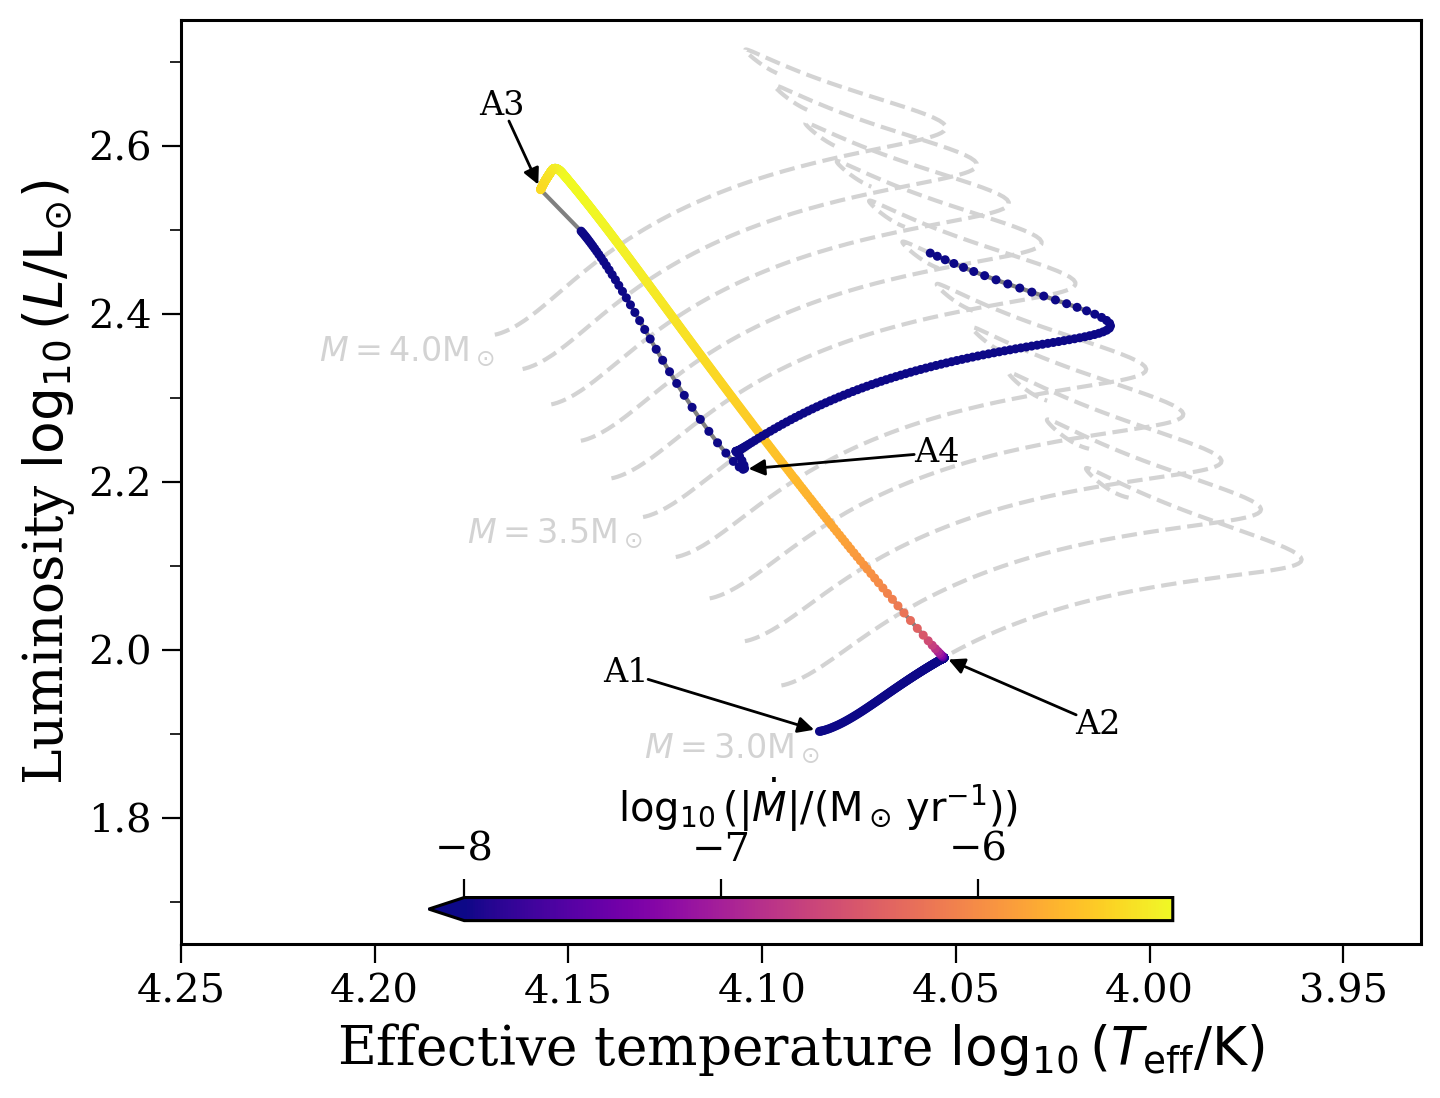

In [32]:
refresh_mpt()
fig, ax = None, None
fig, ax = mpt.simple_hr(tracks["D_20"][1], fig=fig, ax=ax, show=False, s=5,
                        cbar_var="log_abs_mdot", cmap="plasma",
                        cbar_label=r"$\log_{10} (|\dot{M}| / ({\rm M_\odot \, yr^{-1}}))$",
                        cbar_loc=[0.2, 0.025, 0.6, 0.025],
                        vmin=-8, inset_cbar=True, rasterized=True)

fig, ax = mpt.add_singles_tracks(fig, ax, singles["D_20"], Ms=np.arange(3.0, 4.1, 0.1), linestyle="--")
ax.set_ylim(bottom=1.55)

# cut = int(mpt.find_closest_model_number(track, X_c=0.69))
# ax.plot(track.history.loc[cut:]["log_Teff"], track.history.loc[cut:]["log_L"], color="#86d934",
#         linewidth=6.5, zorder=-1)

for xy, offset, c in [(mpt.get_hr_position(tracks["D_20"][1], "zams"), (0.05, 0.07), 'A1'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_start"), (-0.04, -0.08), 'A2'),
                      (mpt.get_hr_position(tracks["D_20"][1], "mt_end"), (0.01, 0.1), 'A3'),
                      (mpt.get_hr_position(tracks["D_20"][1], "cheb"), (-0.05, 0.02), 'A4')]:
    ax.annotate(c, xytext=(xy[0] + offset[0], xy[1] + offset[1]), xy=xy,
                ha="center", va="center", color="black", fontsize=0.5*fs,
                arrowprops=dict(arrowstyle="-|>", color="black"), bbox=dict(pad=-2, fc="none", ec="none"))

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.set(xlim=(4.25, 3.93), ylim=(1.65, 2.75))

# plt.savefig("../paper/figures/HRD_binary_compromise.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

## $X_H$ profile evolution

In [7]:
X_c_panels = [0.69905, 0.53, 0.47, 0.3, 0.1, 0.01]

### Separate Panels

  0%|          | 0/1046 [00:00<?, ?it/s]

100%|██████████| 1046/1046 [00:04<00:00, 230.24it/s]


Parsing M_3.5 (D_20)


100%|██████████| 190/190 [00:00<00:00, 319.86it/s]


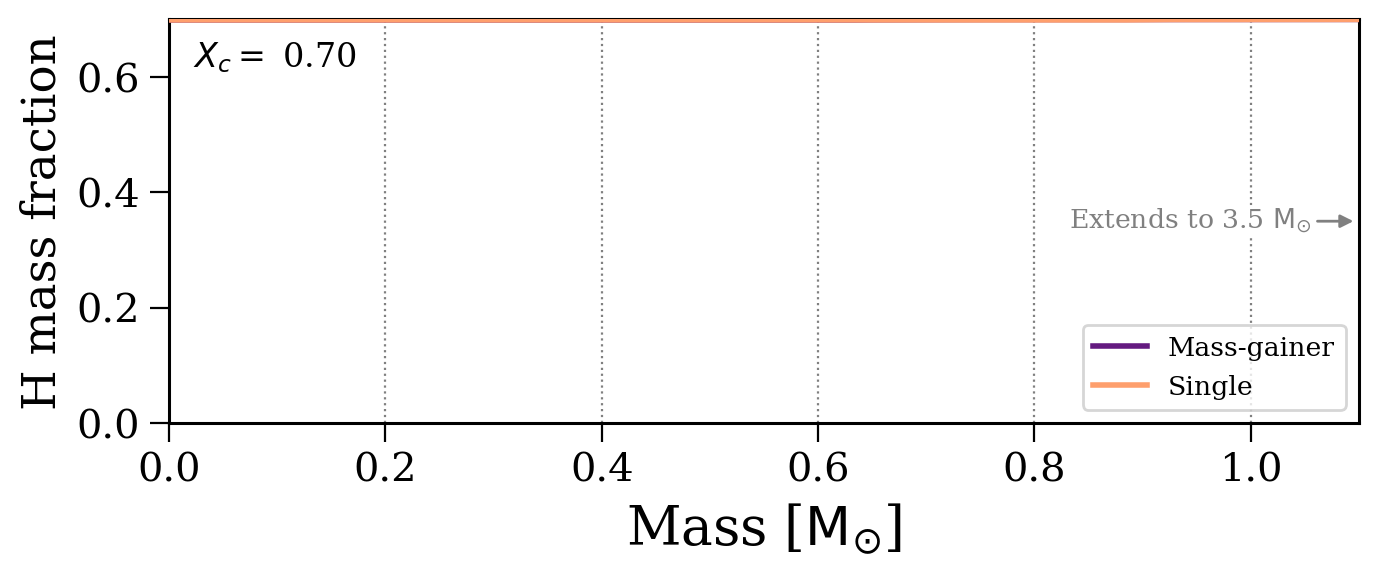

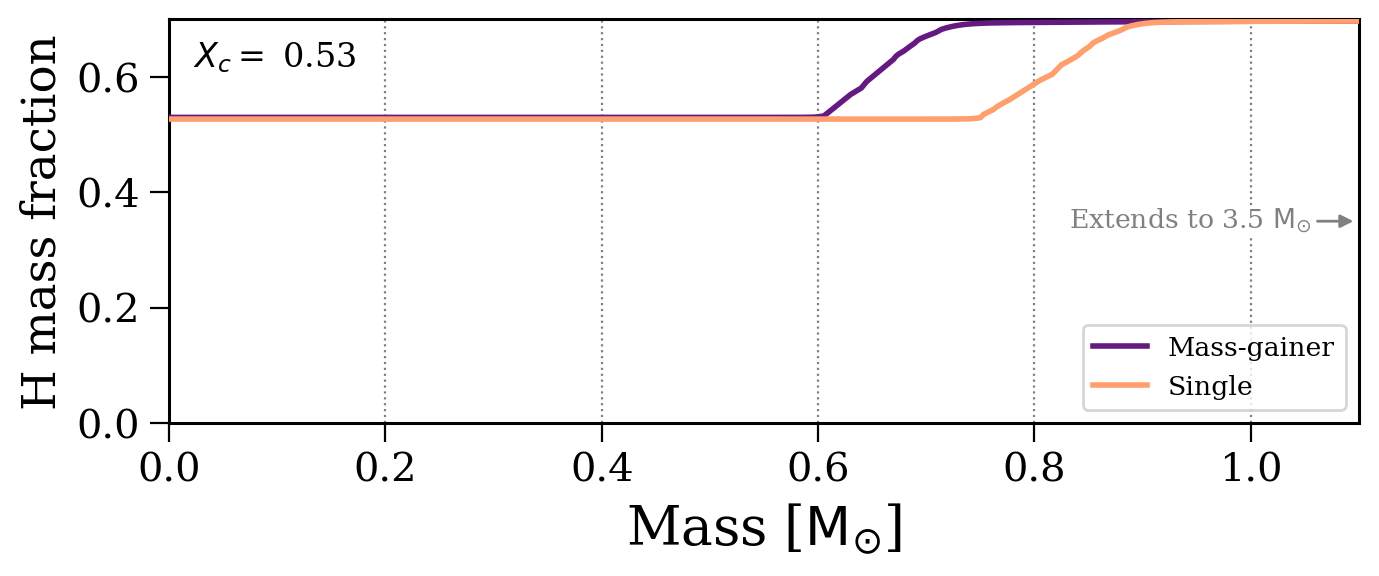

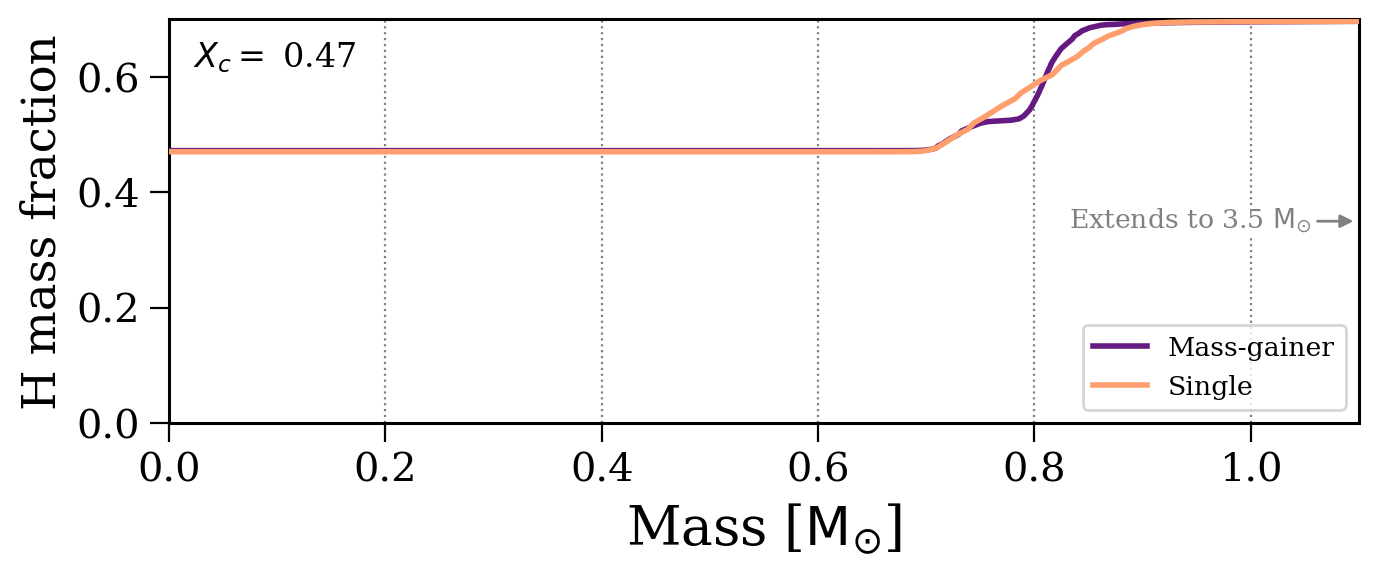

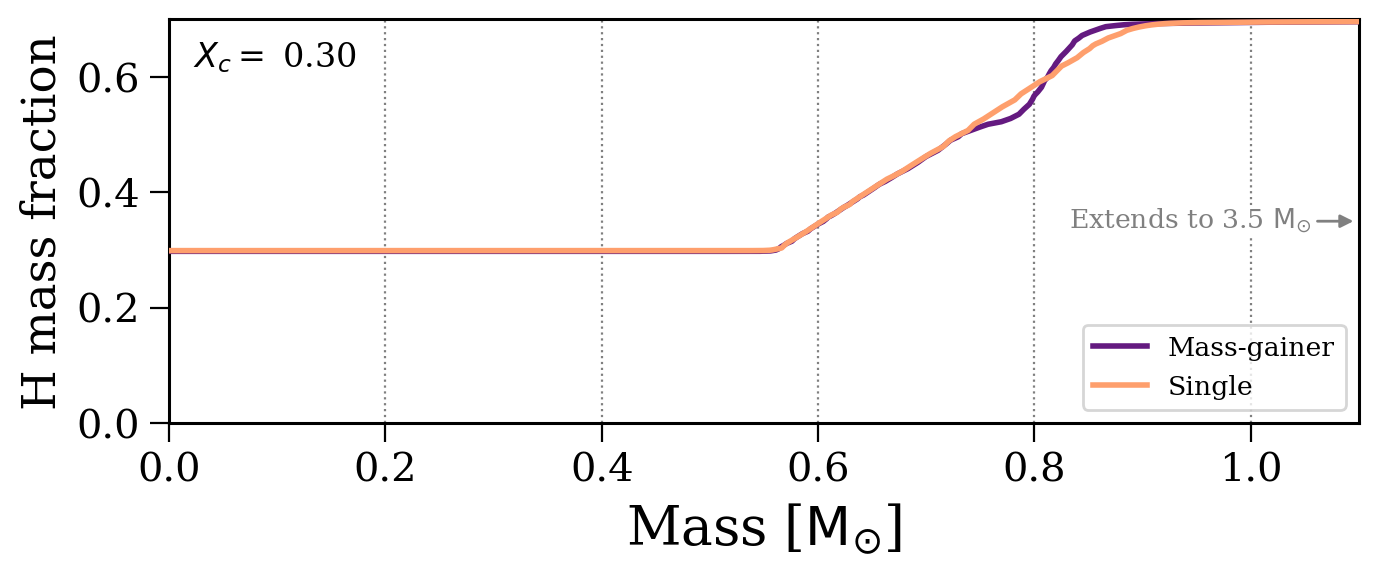

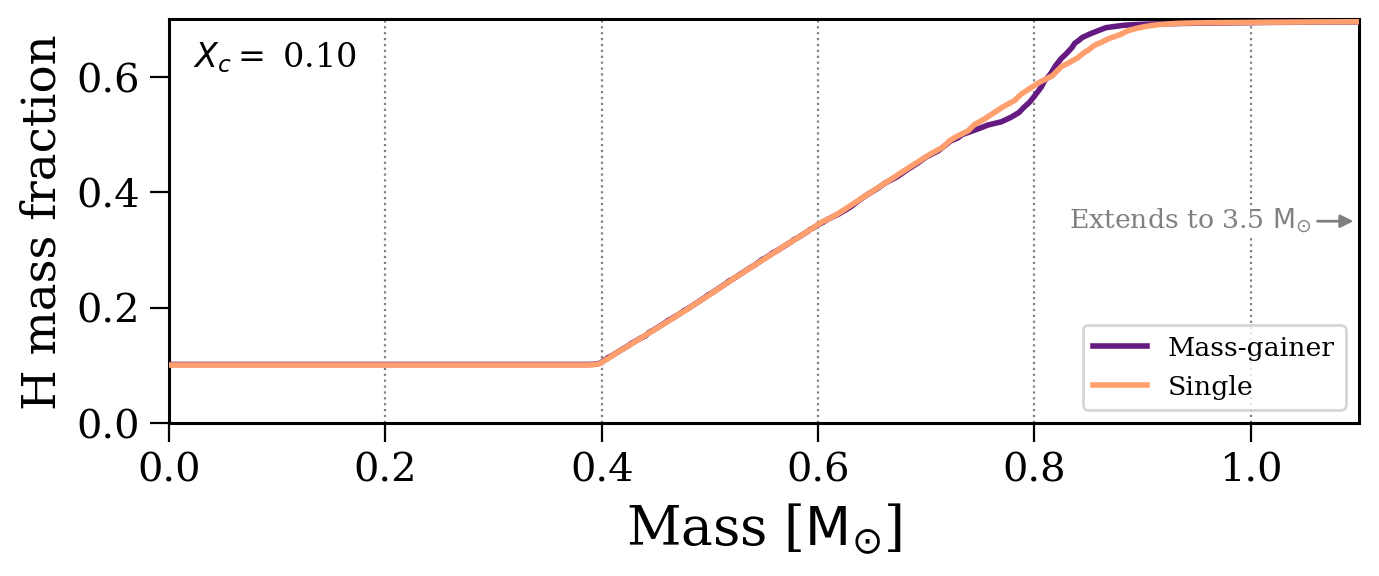

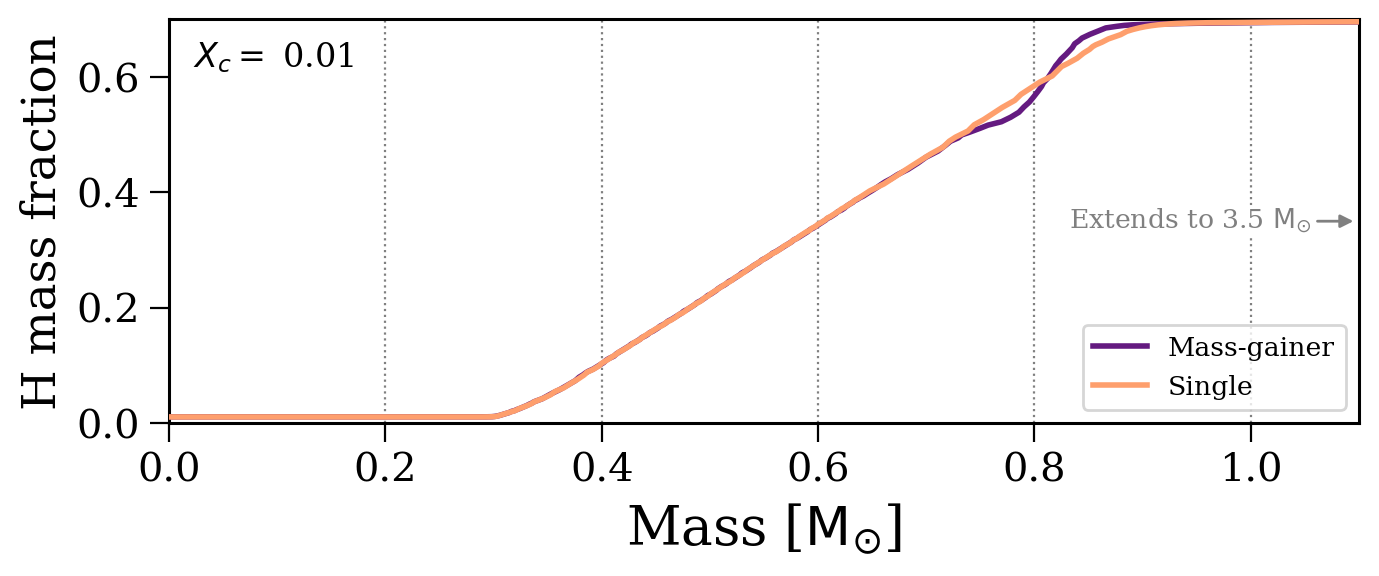

In [18]:
refresh_mpt()
for X_c in X_c_panels:
    fig, ax = mpt.plot_X_H_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                                   show=False, label_with="an", annotate_col="grey")
    ax.grid(axis="x", linestyle="dotted", color="grey")
    # plt.savefig(f"presentation_plots/X_H_profile_mdm20_Xc_{X_c}.png", format="png", bbox_inches="tight", dpi=300)

### Group of subplots

In [33]:
X_c_panels

[0.69905, 0.53, 0.47, 0.3, 0.1, 0.01]

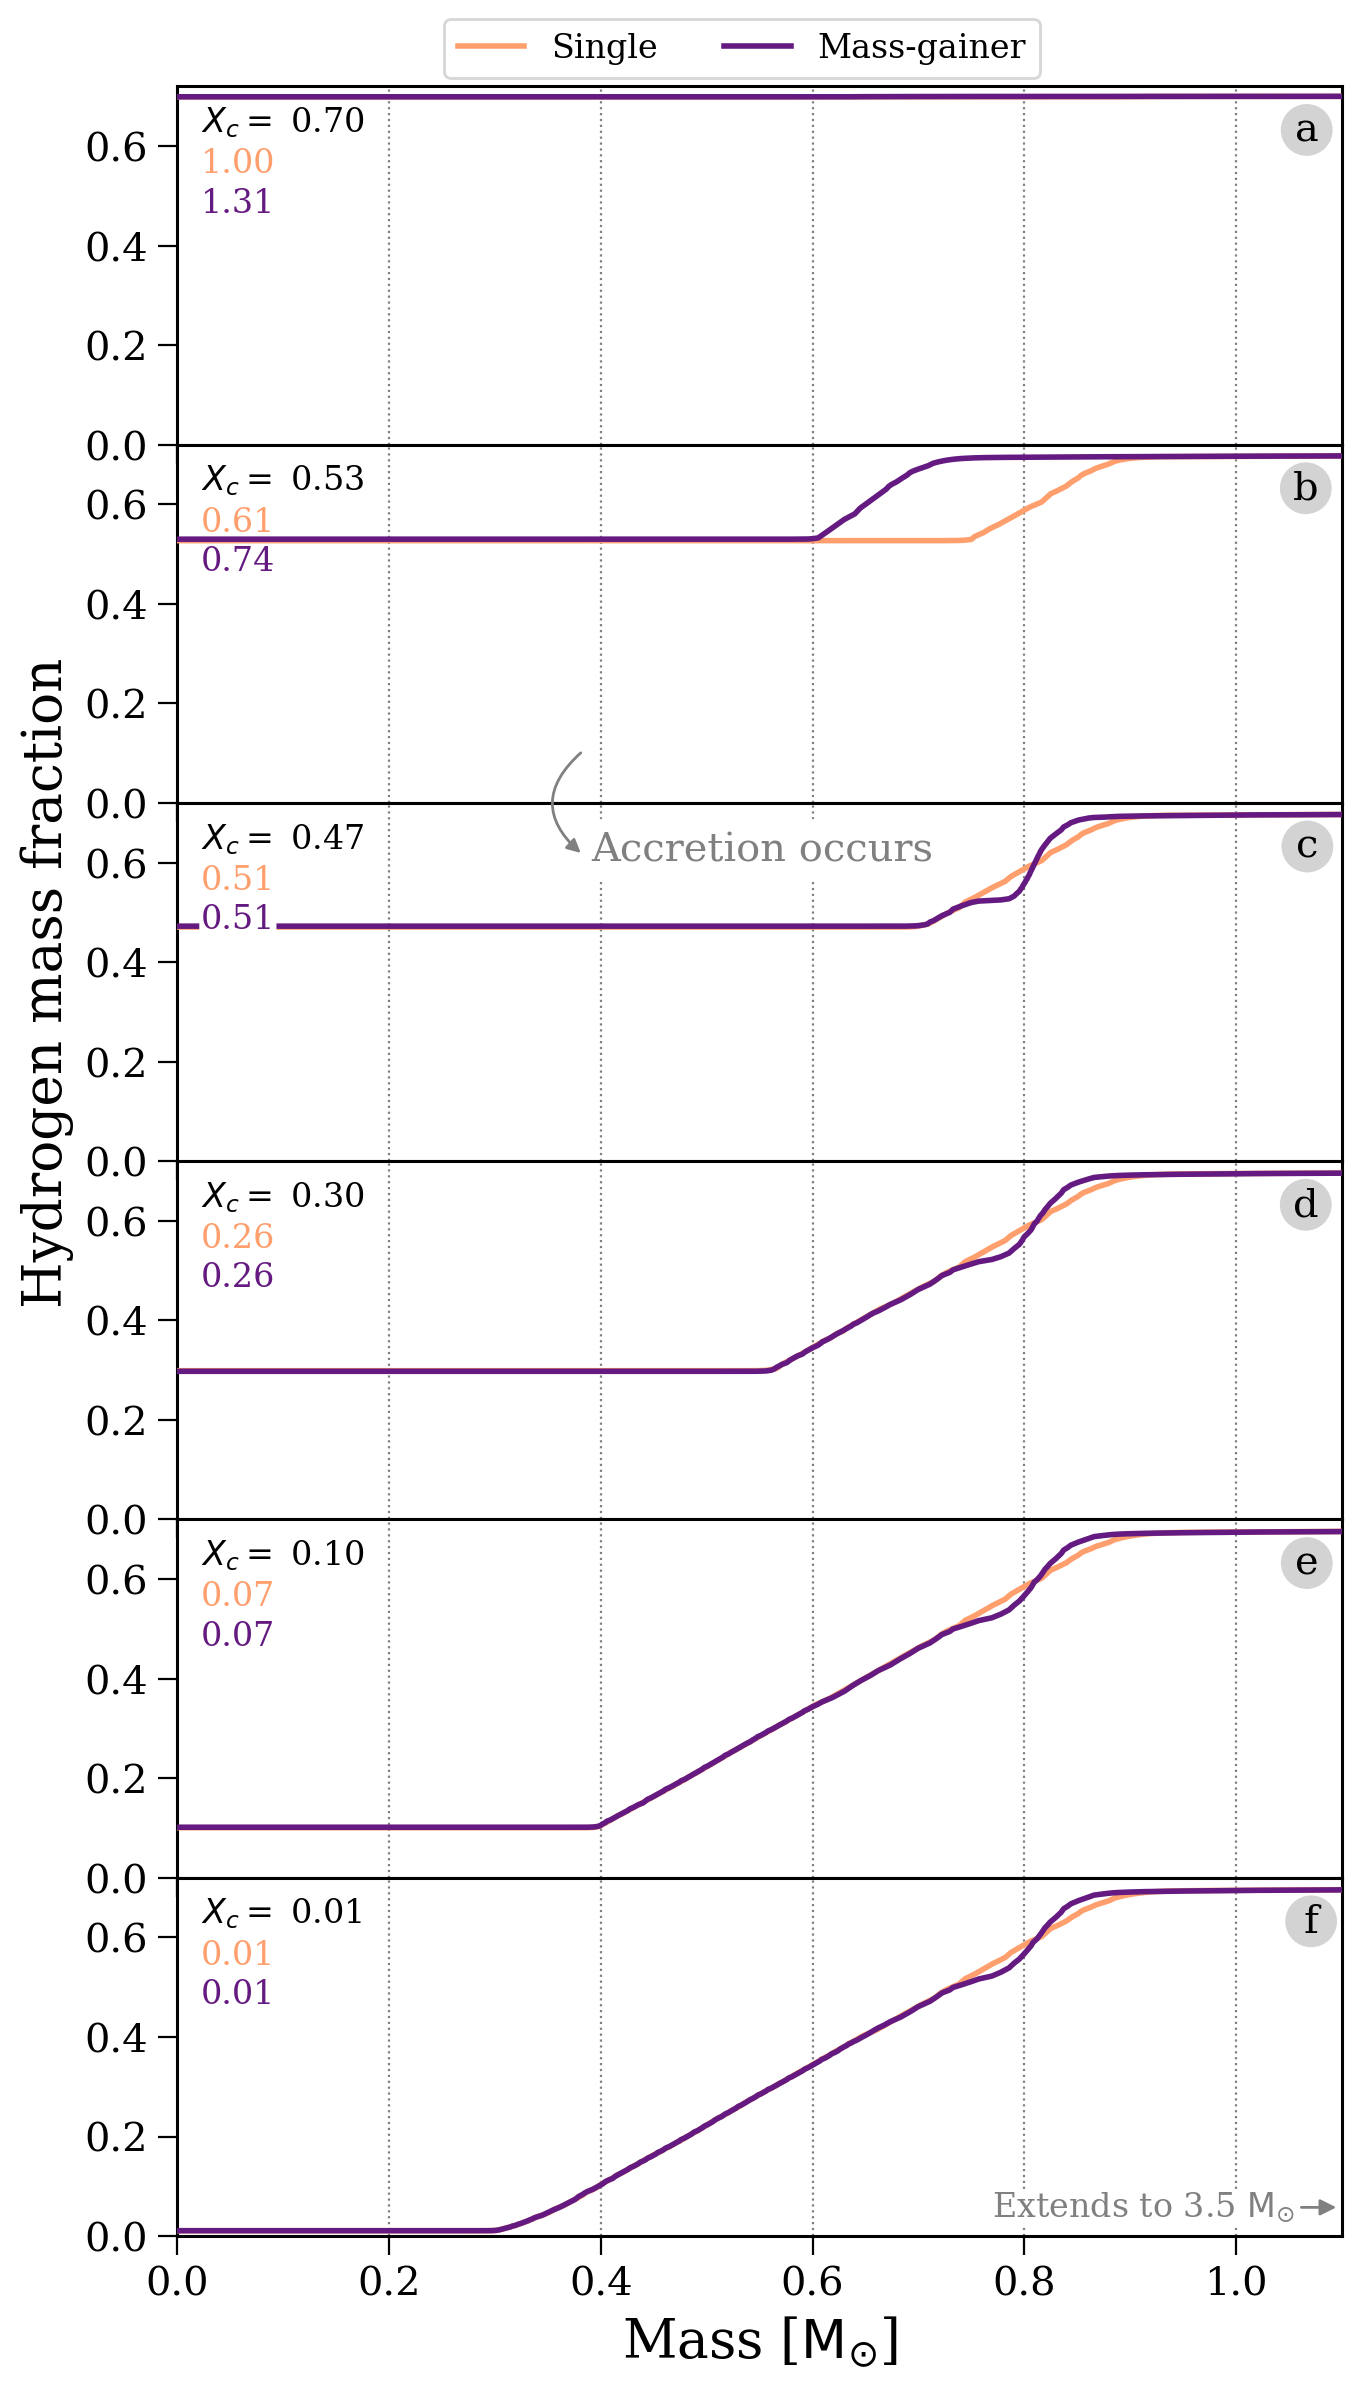

In [45]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 1, figsize=(7, 12), sharex=True, layout="tight")
for X_c, ax in zip(X_c_panels, axes):
    ts = [singles["D_20"]["M_3.5"], tracks["D_20"][1]]
    
    mpt.plot_X_H_profile(X_c=X_c, tracks=ts,
                         fig=fig, ax=ax, show=False, label_with="an", annotate_col="grey")
    ax.grid(axis="x", linestyle="dotted", color="grey")

    for t, c, y, tTAMS in zip(ts, [mpt.single_col, mpt.mass_gainer_col], [0.83, 0.72], [225.96748801989216, 296.7931162299796]):
        mod = mpt.utils.find_closest_model_number(track=t, X_c=X_c)
        # print(t.history.loc[mpt.utils.find_closest_model_number(track=t, X_c=1e-4) - 1]['star_age'] / 1e6)
        ax.annotate(f"{(tTAMS - t.history.loc[mod - 1]['star_age'] / 1e6) / 225.96748801989216:1.2f}", color=c,
                    xy=(0.02, y), xycoords="axes fraction", va="top", fontsize=0.5*fs,
                    bbox=dict(boxstyle="round", pad=0, fc="white", ec="white", alpha=1) if X_c < 0.5 else None,
                    zorder=10)

for ax, letter in zip(axes, "abcdef"):
    if ax != axes[-1]:
        ax.set_xlabel("")
    ax.set_ylabel("Hydrogen mass fraction" if ax == axes[2] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_ylim(top=0.72)

    ax.annotate(letter, xy=(0.98, 0.93), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

accretion_an_x = 0.35
axes[2].annotate("", xytext=(accretion_an_x, 1.15), xy=(accretion_an_x, 0.85), xycoords="axes fraction",
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=40, angleB=-40", lw=1, color='grey'),
                 zorder=100)
axes[2].annotate("Accretion occurs", xy=(accretion_an_x + 0.005, 0.84), xycoords="axes fraction", ha="left",
                 bbox=dict(boxstyle="round", ec='none', fc='white'), color="grey", fontsize=0.6*fs)


ax.annotate(f"Extends to {3.5:1.1f} " + r"$\rm M_{\odot}$", xy=(1, 0.08), xytext=(0.96, 0.08),
            xycoords="axes fraction", ha="right", va="center", color="grey",
            arrowprops=dict(arrowstyle="-|>", color="grey"), fontsize=0.5*fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", pad=0))


fig.legend(*ax.get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.5*fs, ncol=2)

fig.subplots_adjust(hspace=0.0, top=0.965)
# plt.savefig("../paper/figures/XH_profile_all.pdf")
plt.show()

### Zoom in during mass transfer

In [26]:
mpt.set_styles()

In [27]:
def get_years_after_mod(track, mod, years, verbose=True):
    start_time = track.history.loc[mod - 1]["star_age"]
    end_time = start_time + years
    
    diff = np.abs(track.history["star_age"].values - end_time)
    argmin_diff = np.argmin(diff)
    
    actual_time_step = track.history["star_age"].values[np.argmin(diff)] - start_time

    if verbose:
        print(f"The closest time I can find is {actual_time_step / 1e3:1.2f} kyr after this model")
    
    return track.history["model_number"][argmin_diff]

In [28]:
def accretor_rel_MT(track, years=None, rel_to="start", n_steps=5, offset=0, extra_title=None, verbose=False,
                    cmap=plt.get_cmap("cividis_r"), show=True):

    if rel_to == "both":
        accretor_rel_MT(track, years=years, rel_to="start", n_steps=n_steps, offset=offset, extra_title=extra_title, cmap=cmap)
        accretor_rel_MT(track, years=years, rel_to="end", n_steps=n_steps, offset=offset, extra_title=extra_title, cmap=cmap)
        return

    mt_mod_nums = track.history[track.history["log_abs_mdot"] > -10.0]["model_number"]
    mt_start, mt_end = mt_mod_nums.min(), mt_mod_nums.max()

    if years is None:
        if rel_to == "start":
            t_start, t_end = track.history.loc[mt_start - 1]["star_age"], track.history.loc[mt_end - 1]["star_age"]
            t_end += offset
            years = np.geomspace(5e4, t_end - t_start, n_steps)
        else:
            t_start, t_end = track.history.loc[mt_end - 1]["star_age"], track.history.iloc[-1]["star_age"]
            years = np.linspace(t_start, t_end, n_steps) - t_start + offset

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"width_ratios": [16, 1]})
    fig.subplots_adjust(wspace=0.0)

    ax, cbar_ax = axes

    colours = cmap(np.linspace(0, 1, len(years)))
    inds = range(len(years))

    for year, col, ind in zip(years, colours, inds):
        mod = get_years_after_mod(track, mt_start if rel_to == "start" else mt_end, year, verbose=verbose)
        ax.plot(track.profiles[mod - 1]["mass"], track.profiles[mod - 1]["x_mass_fraction_H"], color=col,
                zorder=10 + len(years) - ind, lw=2)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

    if rel_to == "start":
        bounds = (years / 1e6).round(2)#np.log10(years)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                     cax=cbar_ax, label=r"$t - t_{\rm MT, start} \, [\rm Myr]$")
        
        ax.set_ylim(0.4, 0.8)
        ax.set_xlim(0.5, 0.9)
    else:
        norm = mpl.colors.Normalize(vmin=min(years) / 1e6, vmax=max(years) / 1e6)

        cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
        cb1.ax.tick_params(labelsize=0.5*fs)
        cb1.set_label(f"Time after mass\ntransfer {'starts' if rel_to == 'start' else 'ends'} [Myr]", fontsize=0.5*fs)

    ax.set_xlabel(r"Mass $\rm [M_{\odot}]$")
    ax.set_ylabel(r"Hydrogren mass fraction", fontsize=0.7*fs)

    # title = f"Accretor composition ({'During' if rel_to == 'start' else 'Post'} MT)"
    # title = title + f" - {extra_title}" if extra_title is not None else title
    # ax.set_title(title)

    if show:
        plt.show()
    return fig, ax

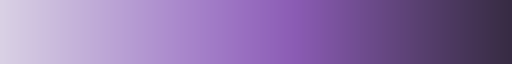

In [29]:
def cmap_from_colour(colour):
    r, g, b, _ = mpl.colors.to_rgba(colour)
    h, s, l = sns.external.husl.rgb_to_husl(r, g, b)
    xx = np.linspace(-1, 1, int(1.15 * 256))[:256]
    ramp = np.zeros((256, 3))
    ramp[:, 0] = h
    ramp[:, 1] = s * np.cos(xx)
    ramp[:, 2] = np.linspace(20, 85, 256)
    colors = np.clip([sns.external.husl.husl_to_rgb(*hsl) for hsl in ramp], 0, 1)
    return mpl.colors.ListedColormap(colors[::-1])
cmap_from_colour("tab:purple")

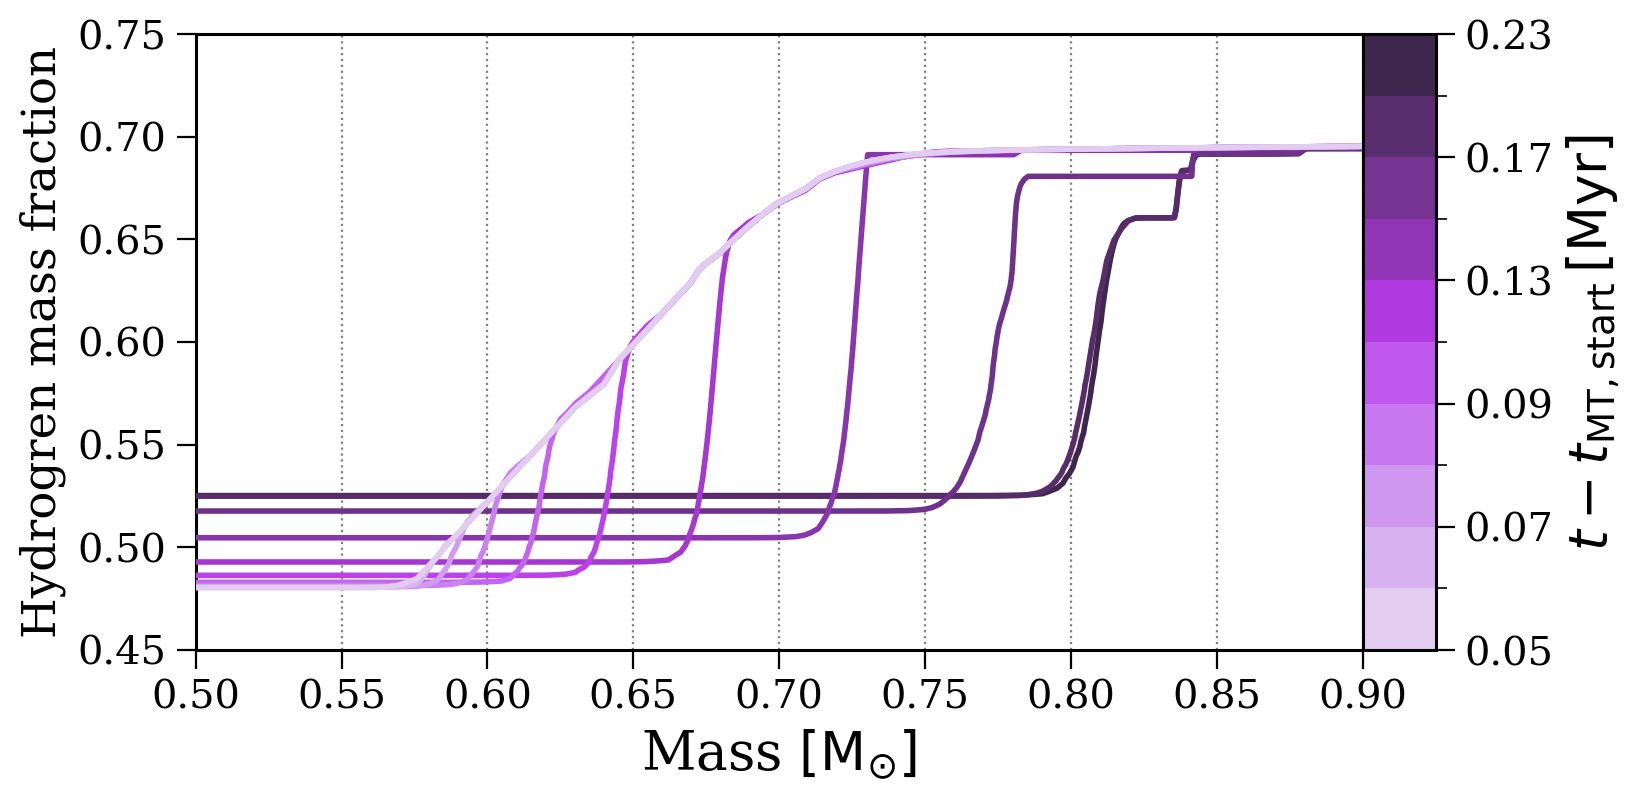

In [30]:
fig, ax = accretor_rel_MT(track=tracks["D_20"][1], rel_to='start', offset=7e4, n_steps=11,
                          cmap=cmap_from_colour(mpt.mass_gainer_col), show=False)

ax.grid(axis="x", linestyle="dotted", color="grey")
ax.set_ylim(0.45, 0.75)

# plt.savefig("../paper/figures/XH_profile_zoom_MT.pdf", format="pdf", bbox_inches="tight")

plt.show()

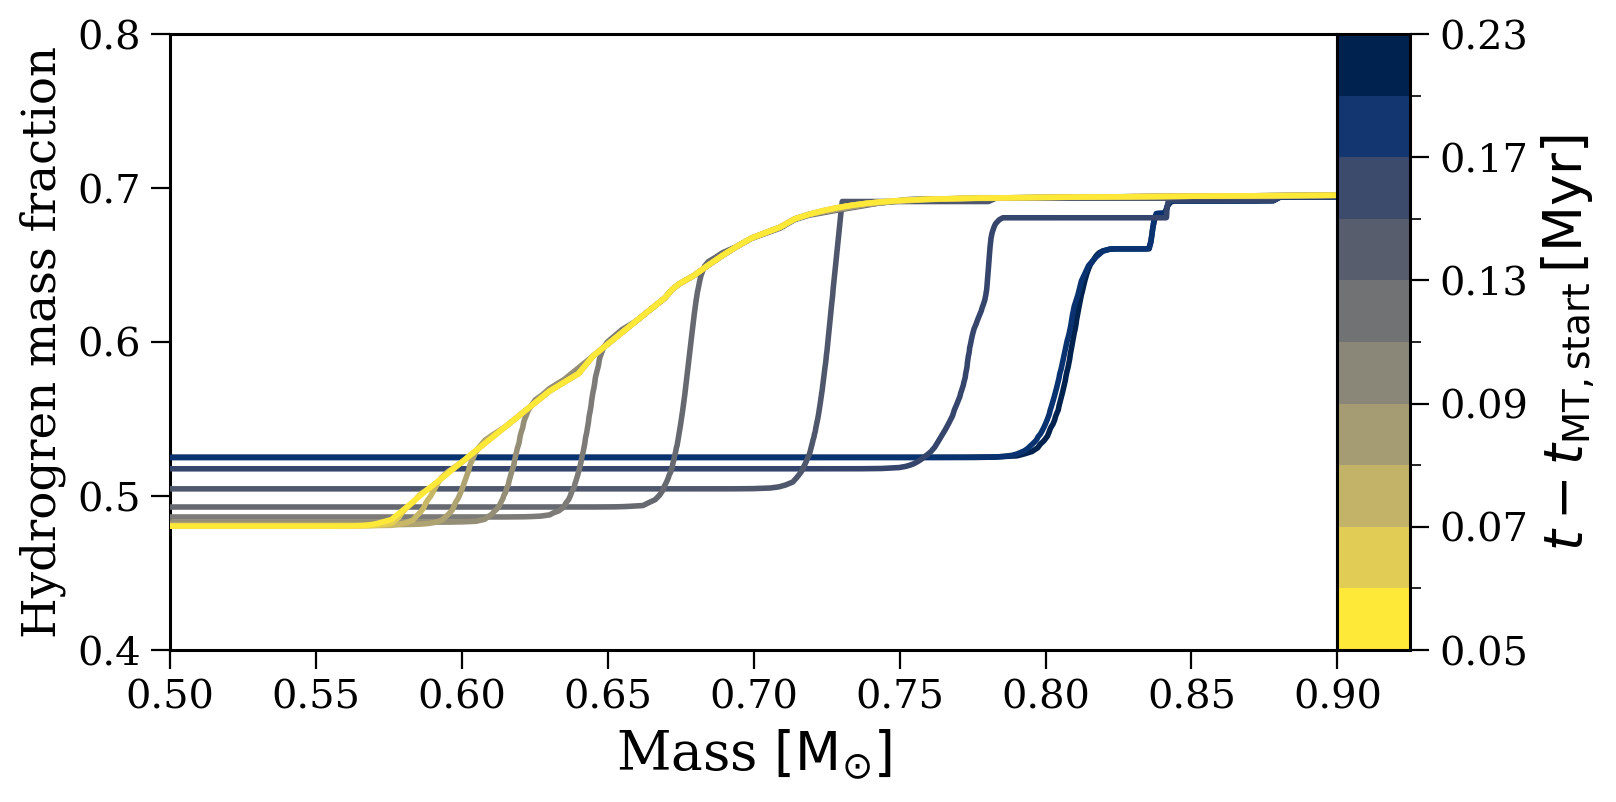

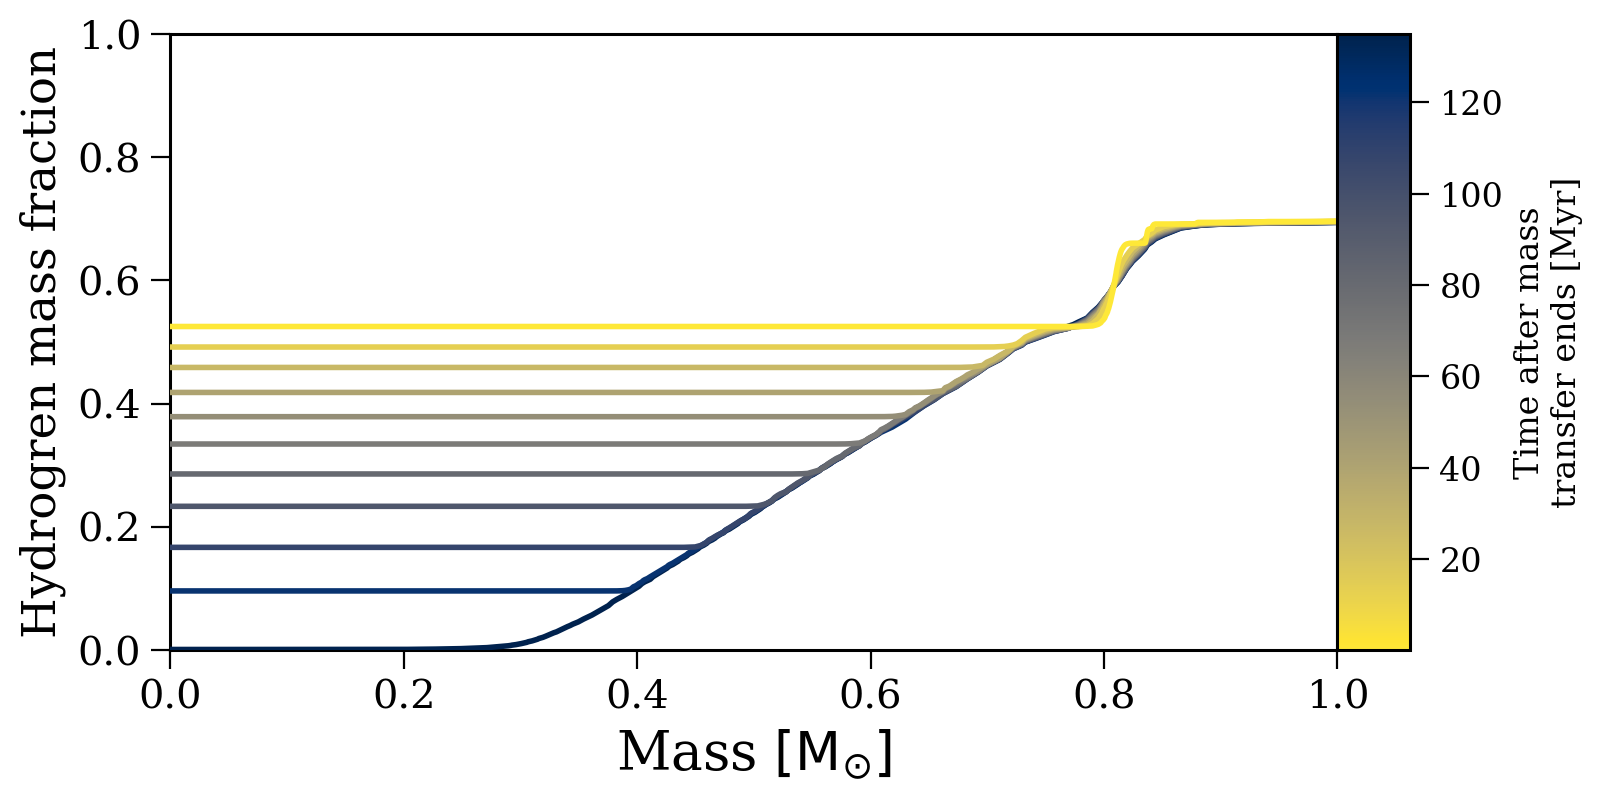

In [31]:
accretor_rel_MT(track=tracks["D_20"][1], rel_to='both', offset=7e4, n_steps=11, cmap=mpl.cm.cividis_r)

# Asteroseismic Signals

## Brunt-Vaisala Profiles

### Separate Panels

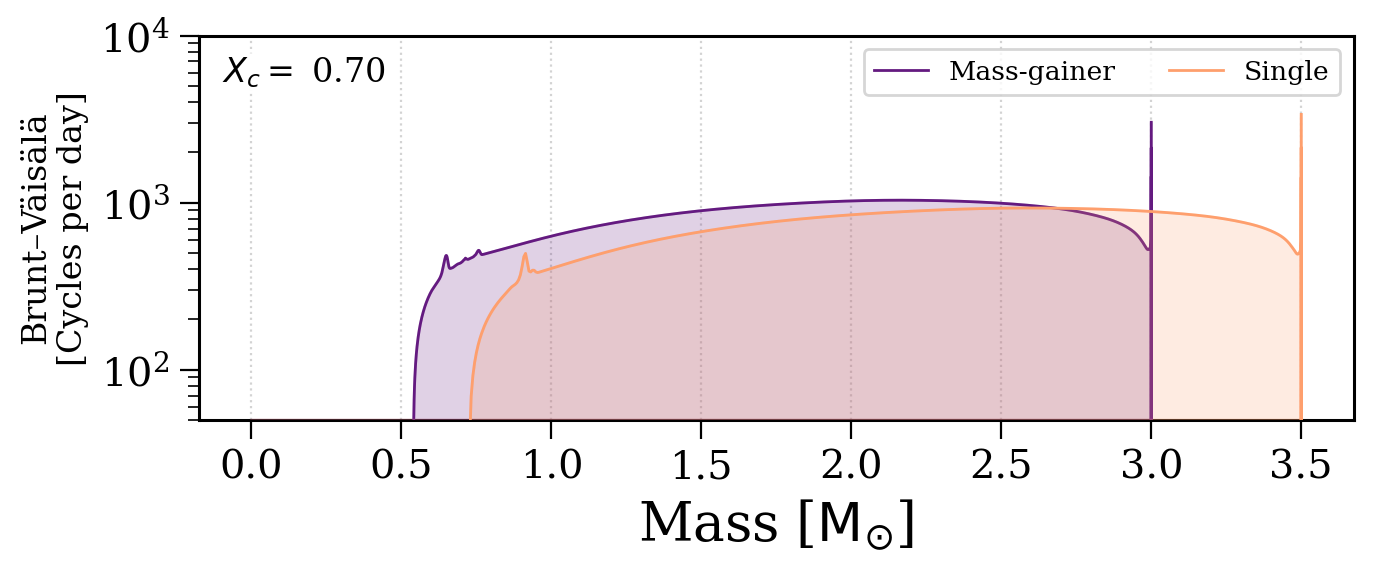

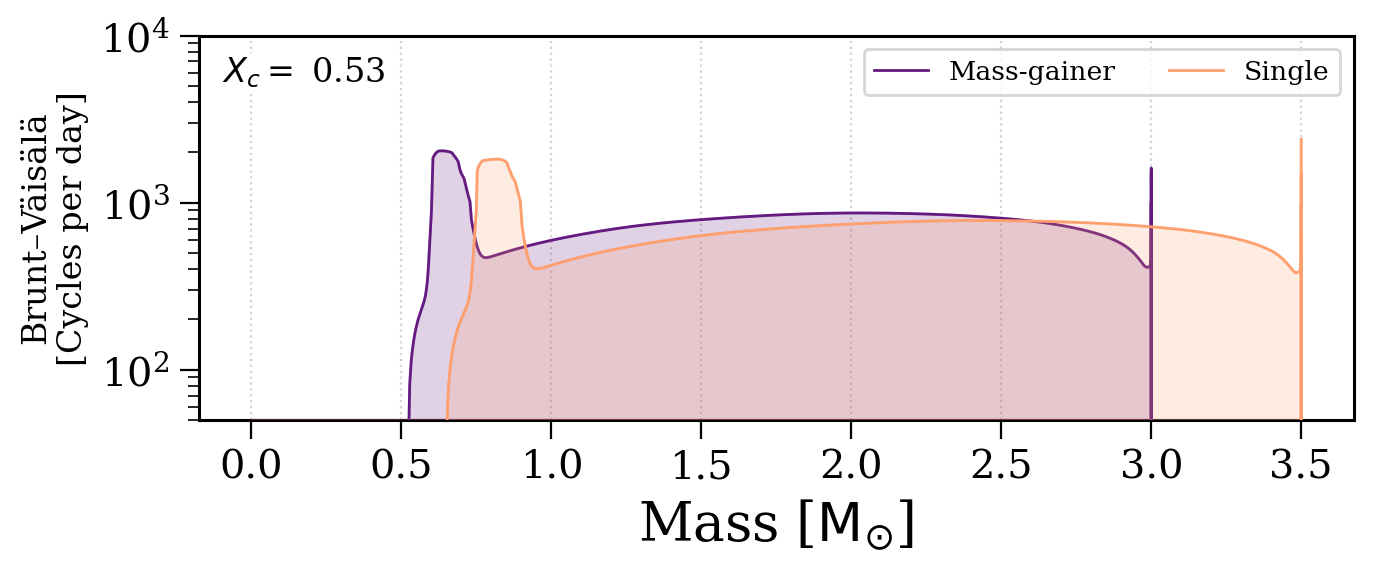

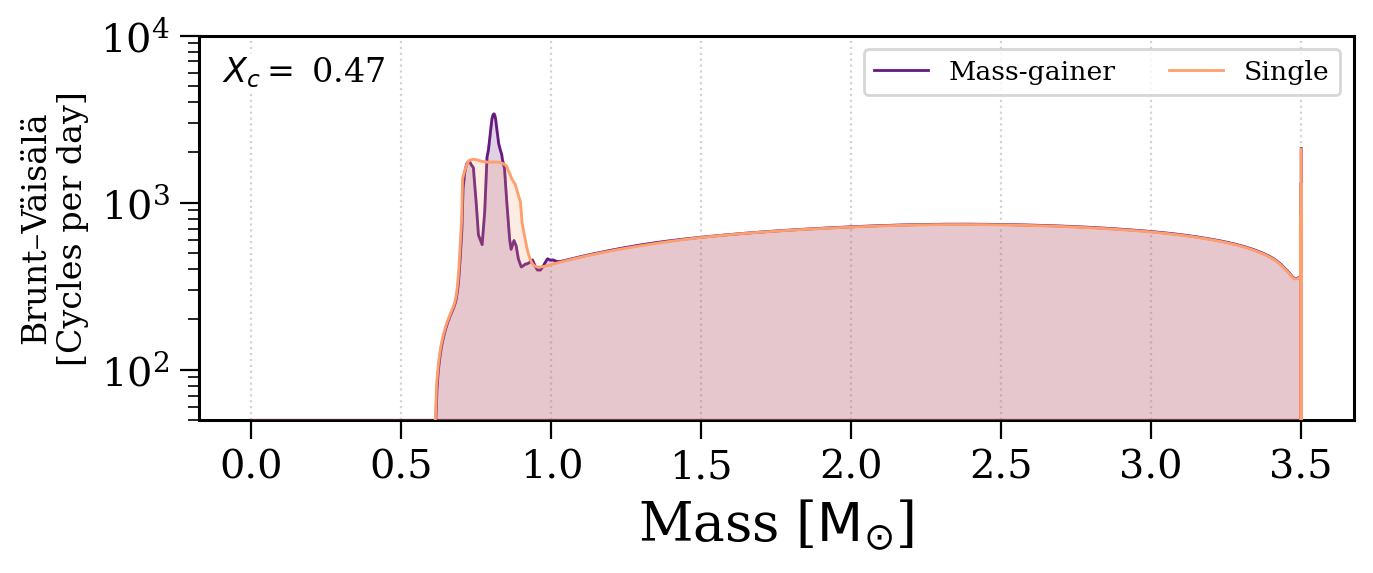

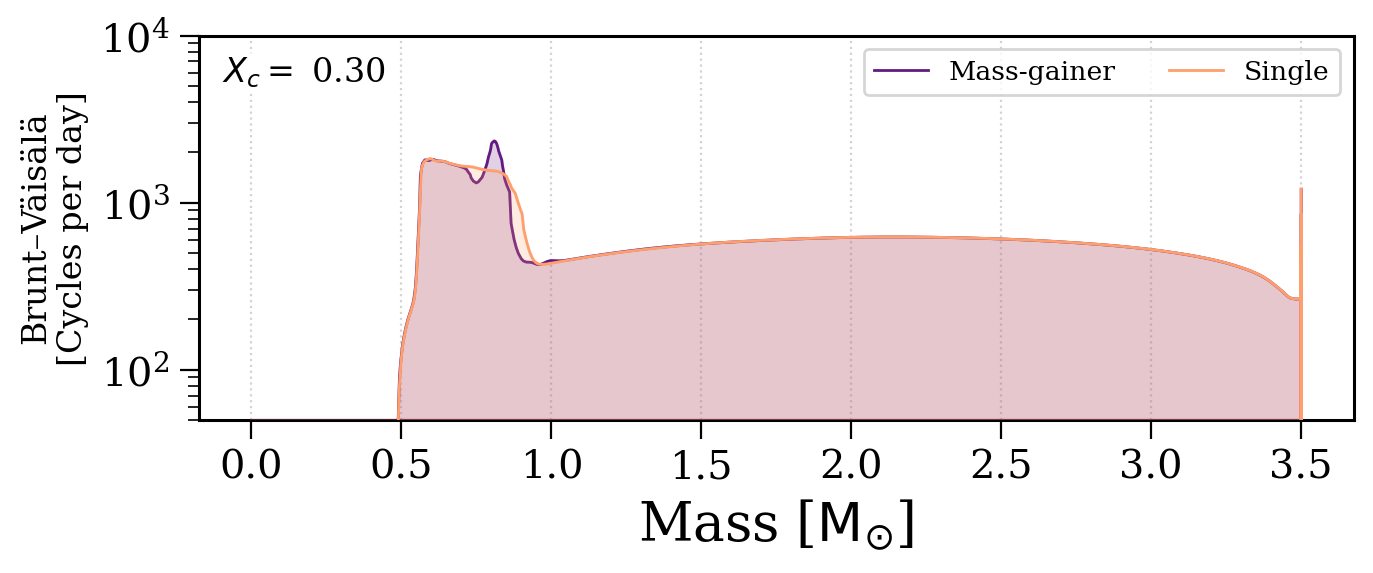

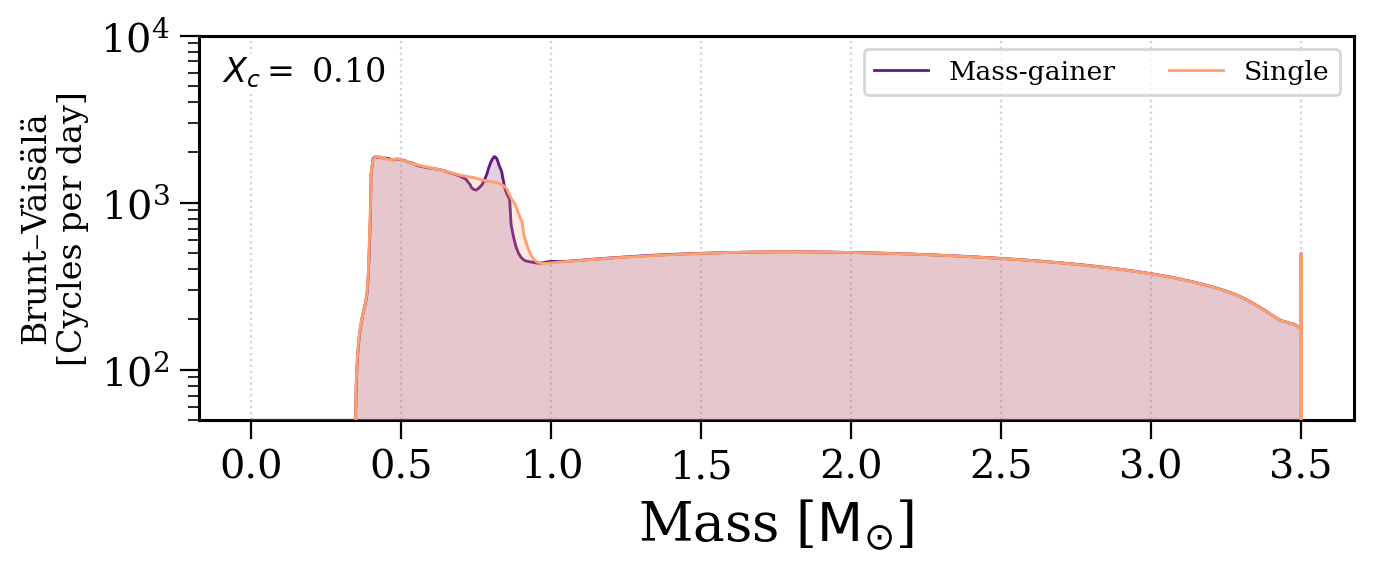

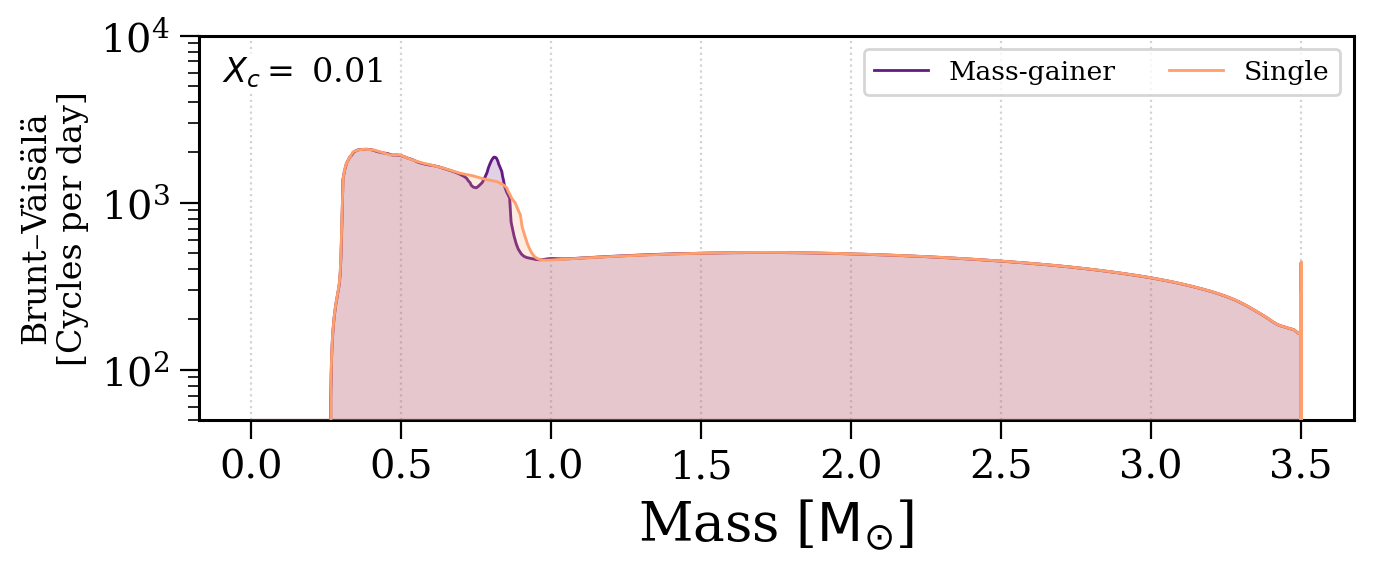

In [32]:
refresh_mpt()
for X_c in X_c_panels:
    fig, ax = mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                                  show=False, label_with="an")
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

### Group of subplots

/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/profiles.py:119: UserWarning: The figure layout has changed to tight
  


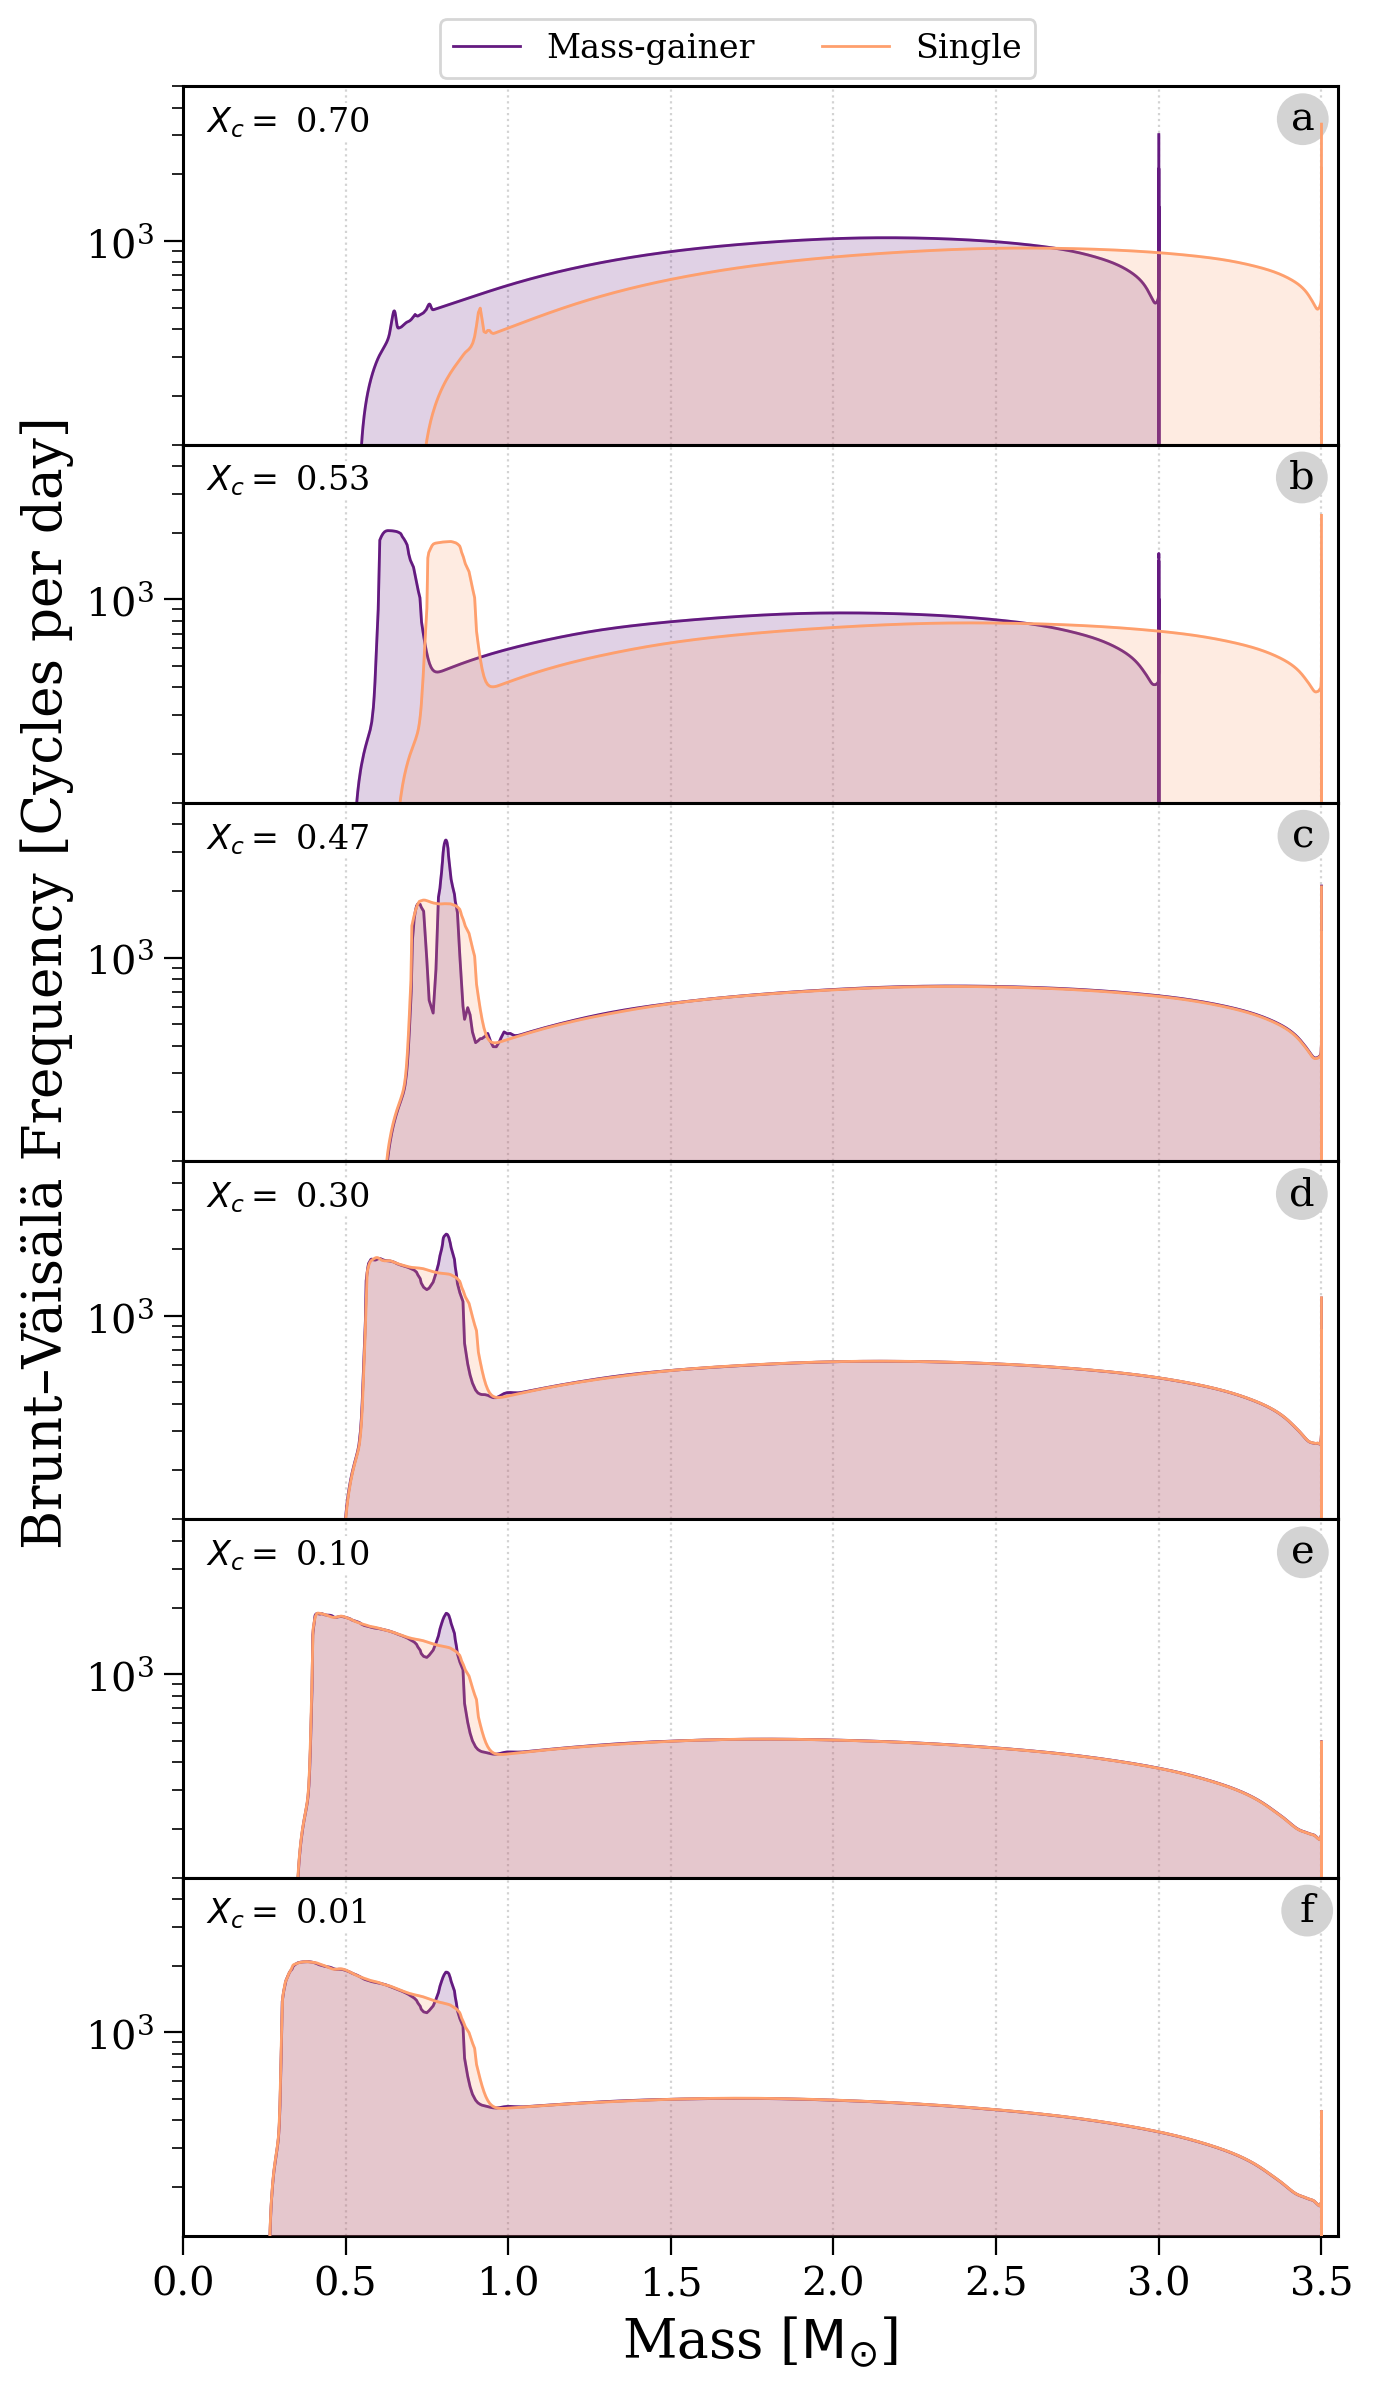

In [33]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 1, figsize=(7, 12), sharex=True)
for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                         fig=fig, ax=ax, show=False, label_with="an")
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for ax, letter in zip(axes, "abcdef"):
    if ax != axes[-1]:
        ax.set_xlabel("")
    ax.set_ylabel("Brunt–Väisälä Frequency [Cycles per day]" if ax == axes[2] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_xlim(0.0, 3.55)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))


fig.legend(*ax.get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.5*fs, ncol=2)

fig.subplots_adjust(hspace=0.0, top=0.965)
# plt.savefig("../paper/figures/BV_profile_all.pdf")
plt.show()

### By radius

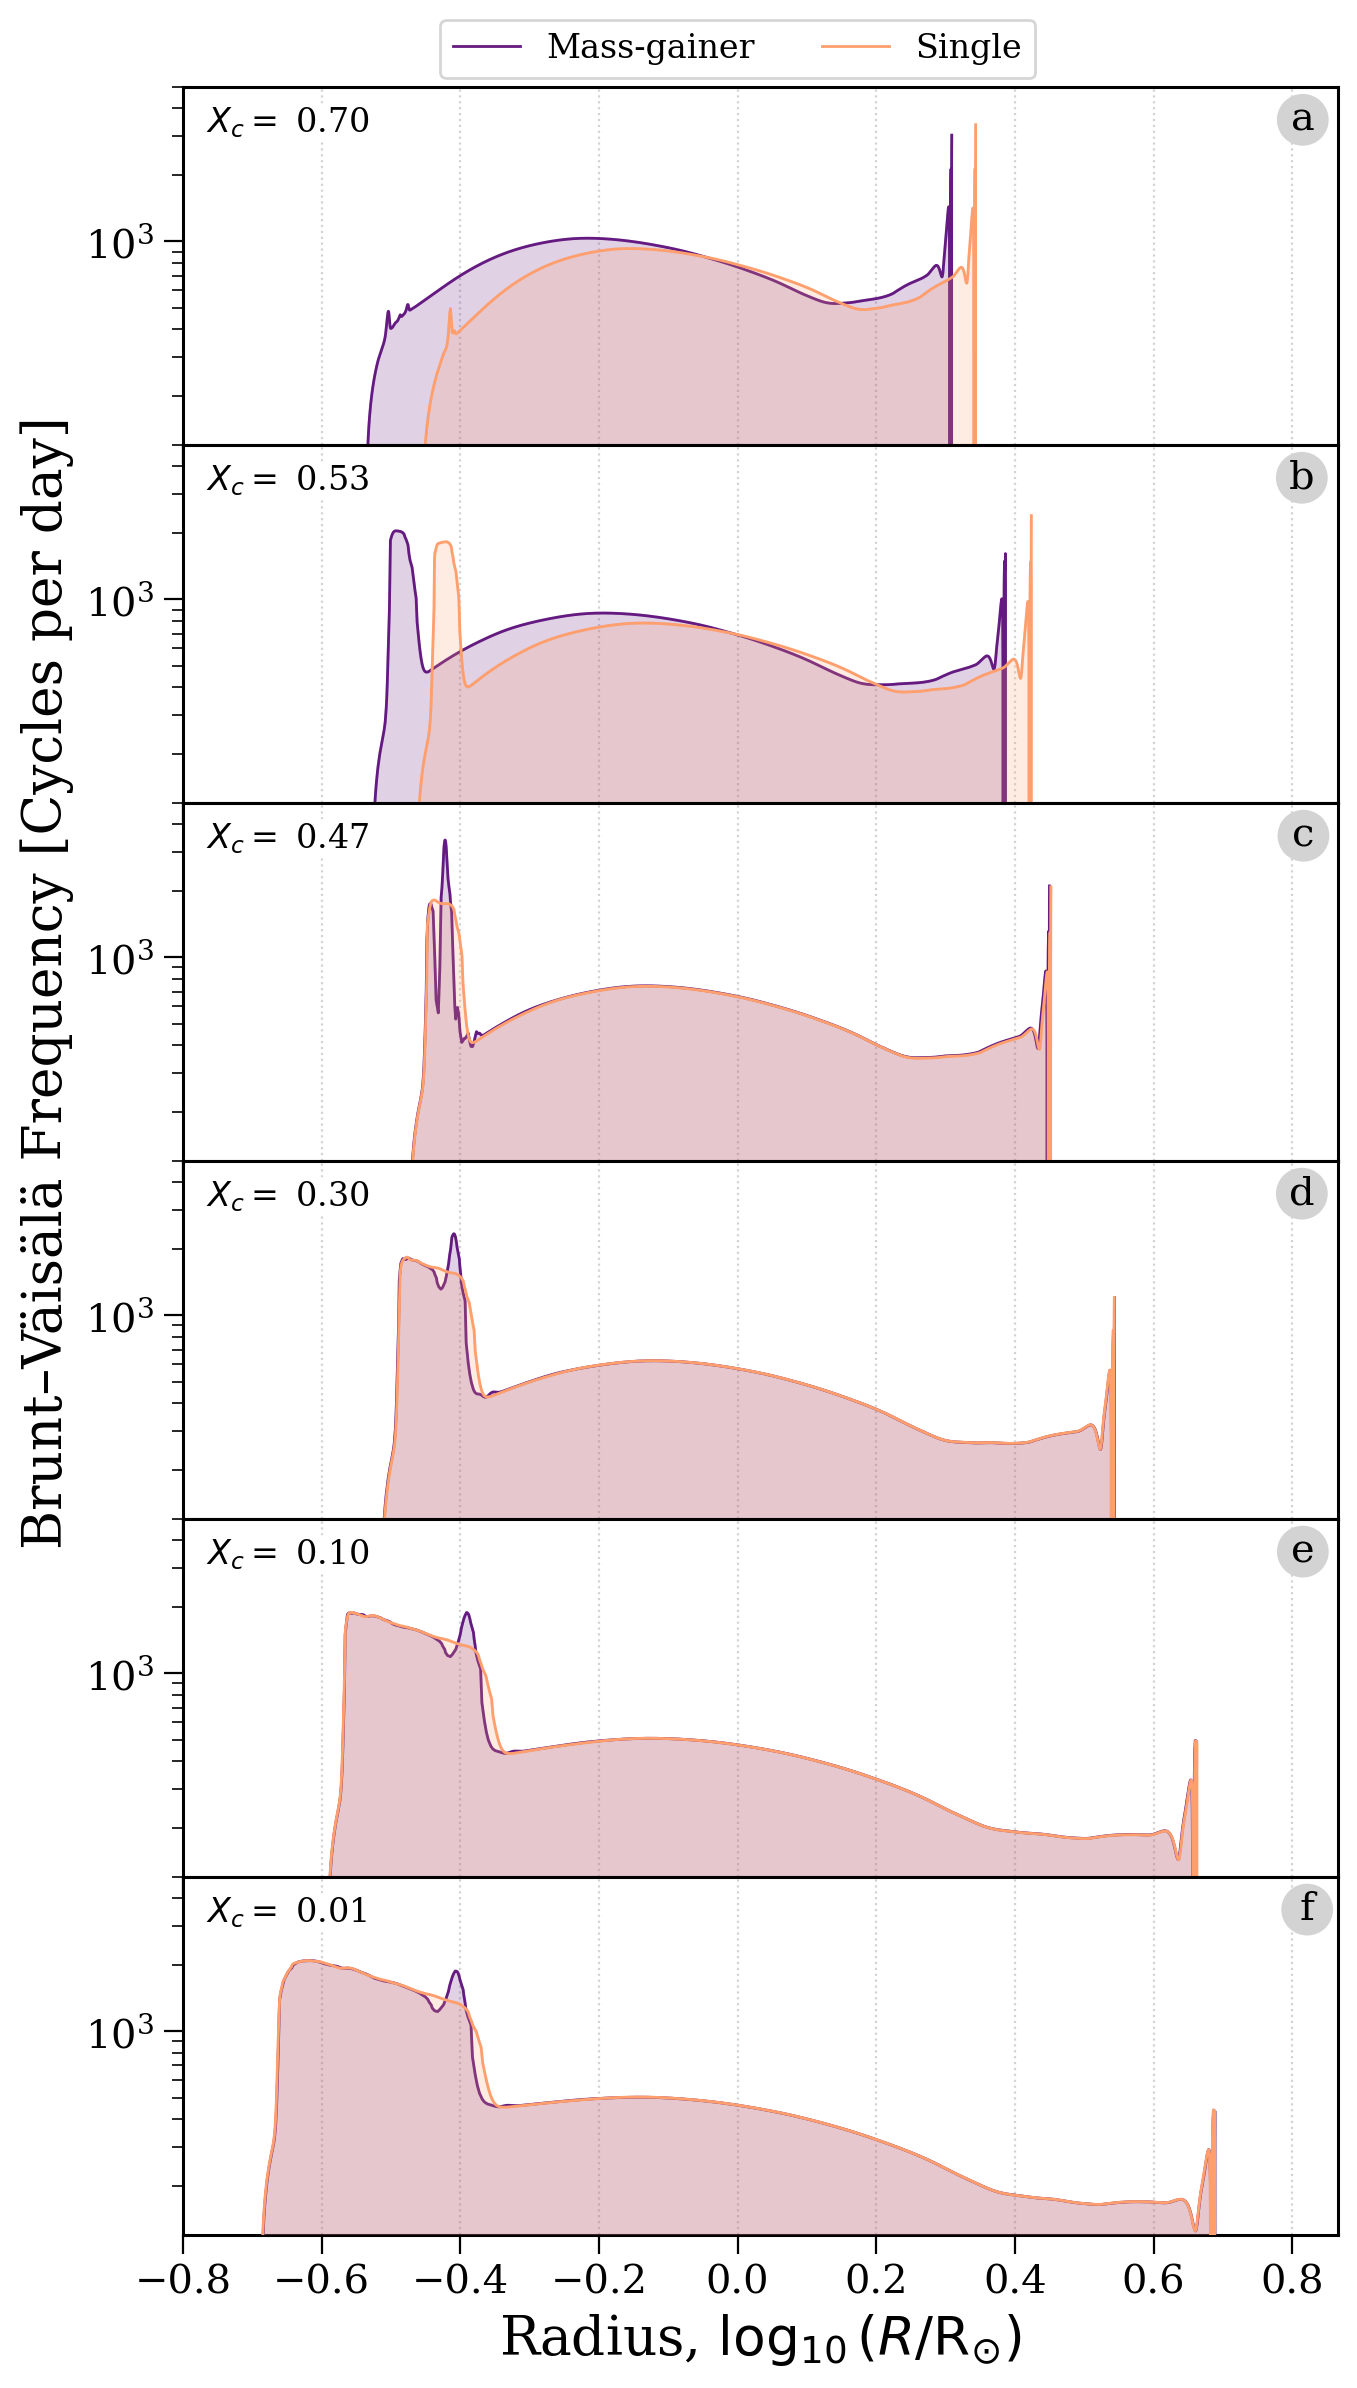

In [34]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 1, figsize=(7, 12), sharex=True)
for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                         fig=fig, ax=ax, show=False, label_with="an", log_radius=True)
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for ax, letter in zip(axes, "abcdef"):
    if ax != axes[-1]:
        ax.set_xlabel("")
    ax.set_ylabel("Brunt–Väisälä Frequency [Cycles per day]" if ax == axes[2] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_xlim(left=-0.8)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))


fig.legend(*ax.get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.5*fs, ncol=2)

fig.subplots_adjust(hspace=0.0, top=0.965)
# plt.savefig("../paper/figures/BV_profile_all.pdf")
plt.show()

### Combo

In [118]:
mpl.colors.rgb2hex(mpt.utils.single_col)

'#fe9f6d'

In [116]:
mpt.utils.mass_gainer_col

(0.390384, 0.100379, 0.501864, 1.0)

/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/profiles.py:119: UserWarning: The figure layout has changed to tight
  


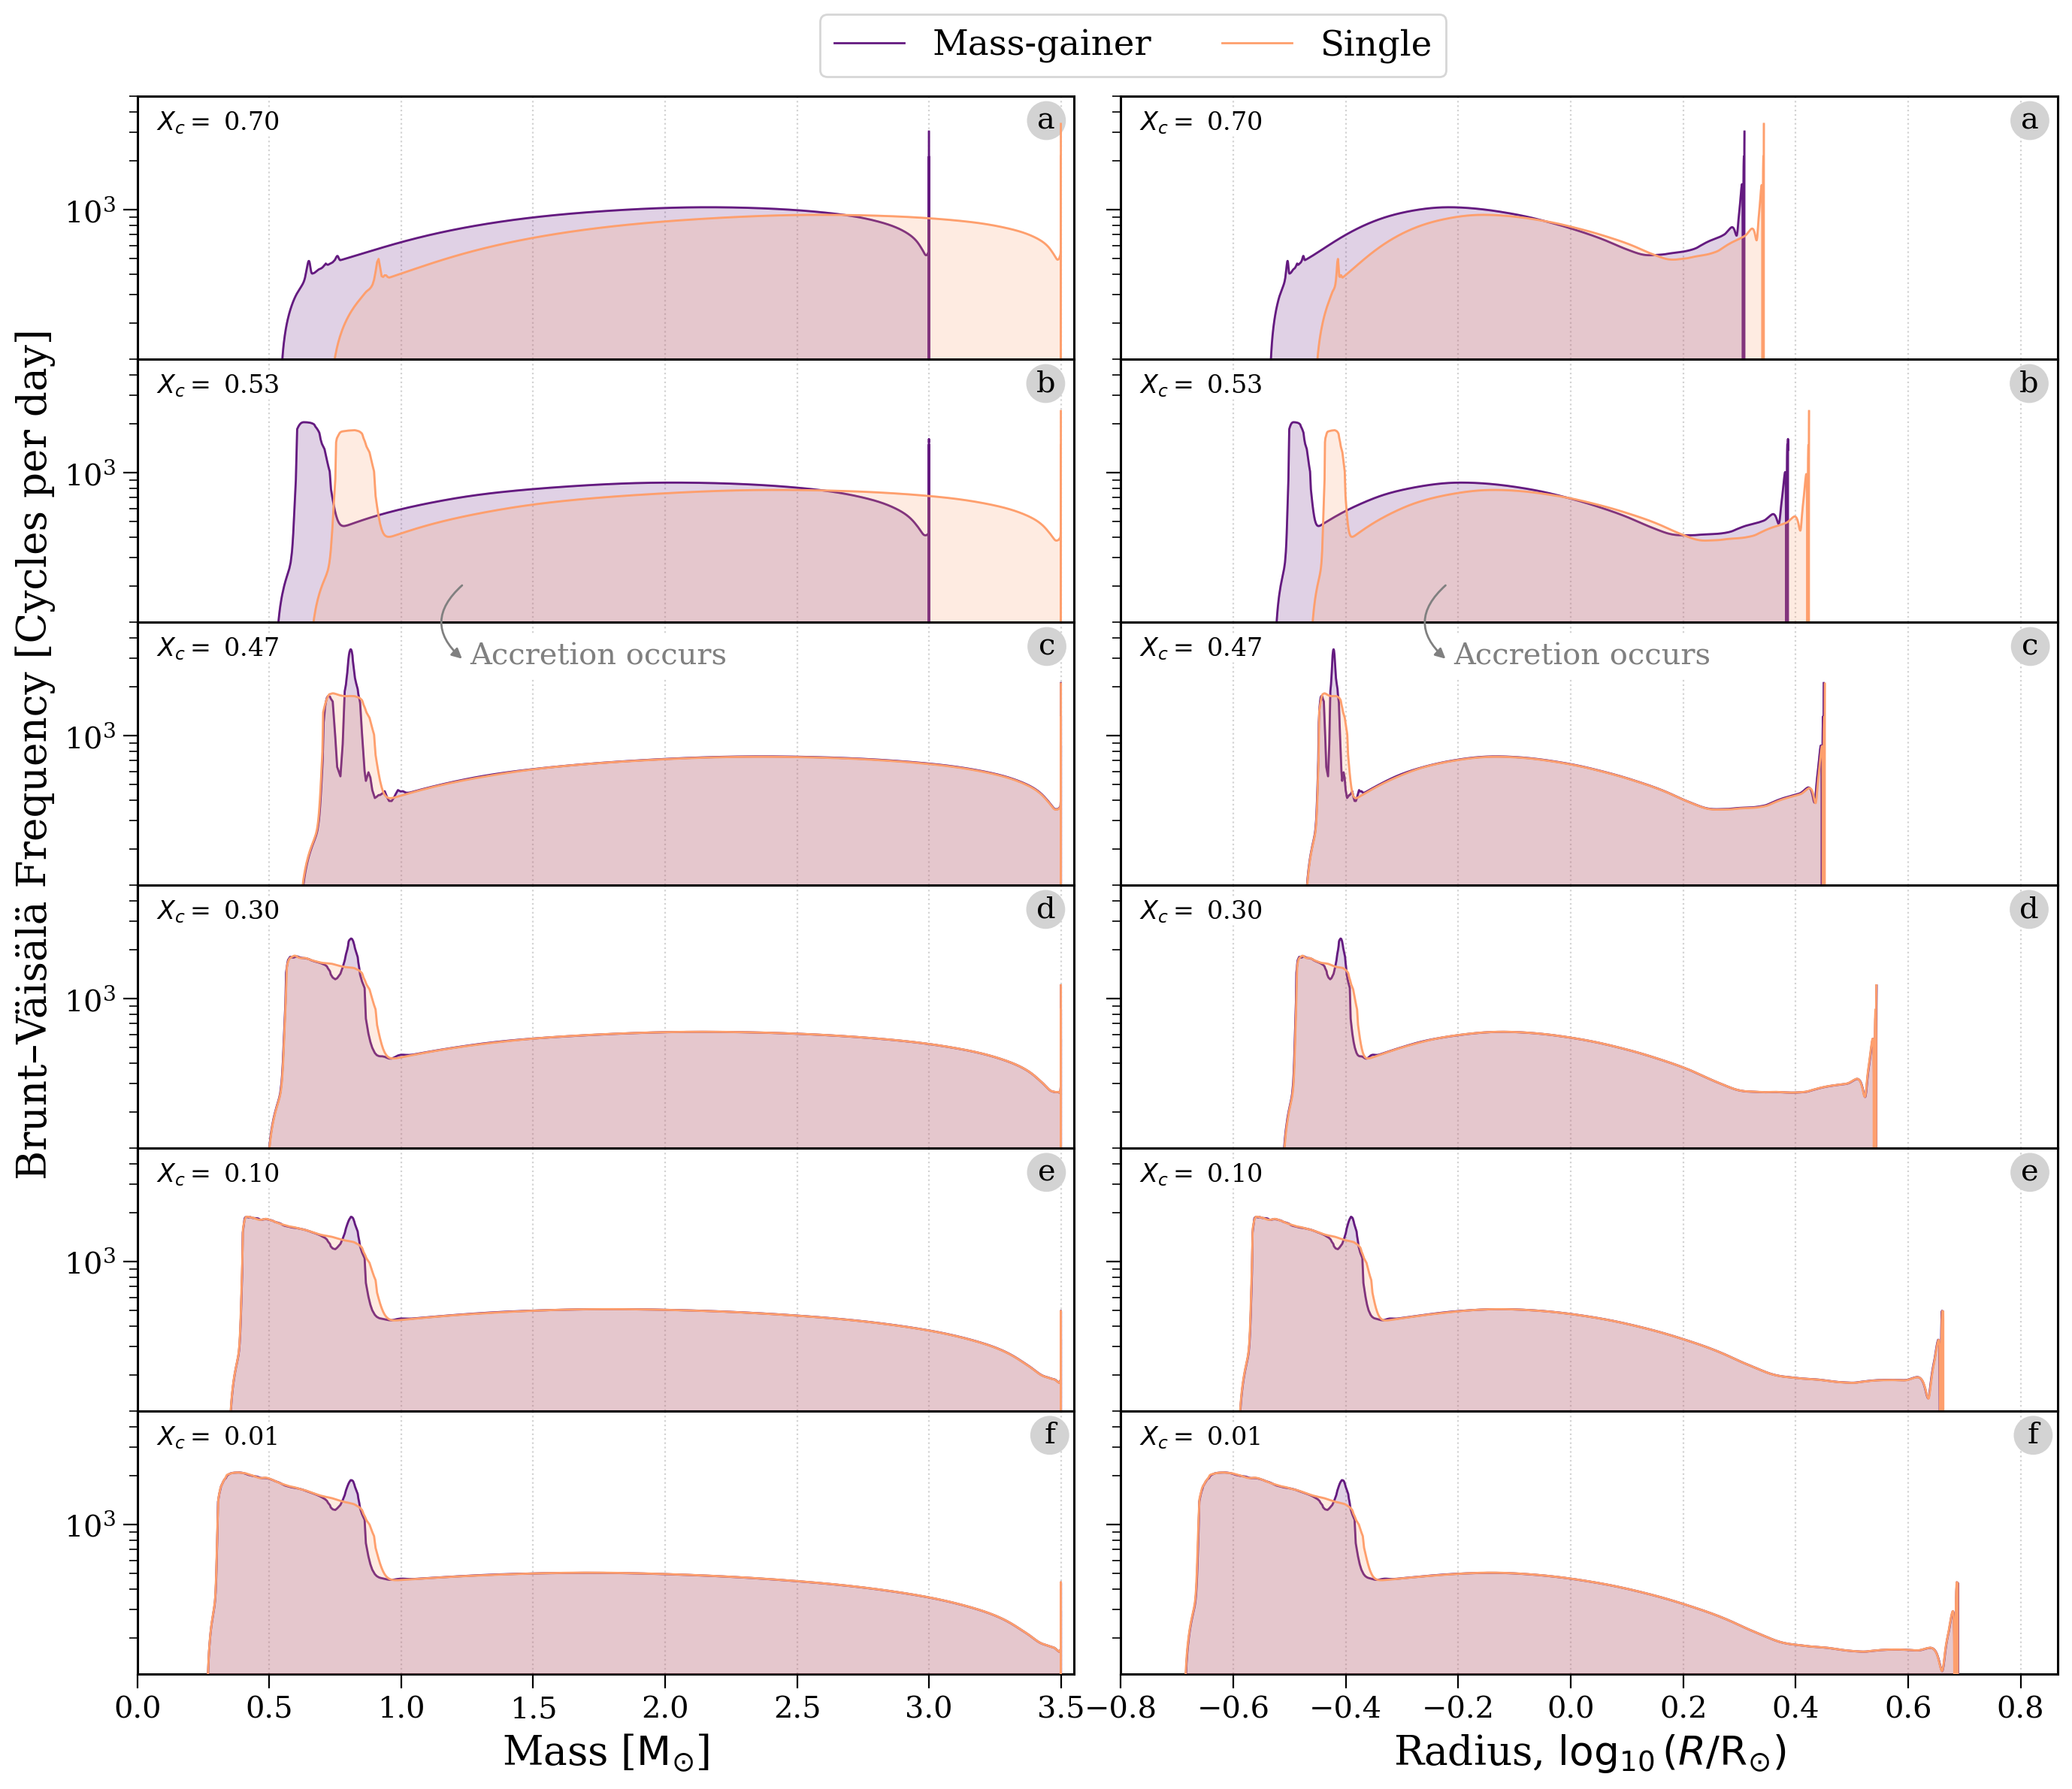

In [52]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 2, figsize=(14, 12), sharex='col', sharey=True)
for X_c, ax in zip(X_c_panels, axes[:, 0]):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                         fig=fig, ax=ax, show=False, label_with="an")
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for X_c, ax in zip(X_c_panels, axes[:, 1]):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                         fig=fig, ax=ax, show=False, label_with="an", log_radius=True)
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for ax, letter in zip(axes[:, 0], "abcdef"):
    if ax != axes[-1, 0]:
        ax.set_xlabel("")
    ax.set_ylabel("Brunt–Väisälä Frequency [Cycles per day]" if ax == axes[2, 0] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_xlim(0.0, 3.55)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

for ax, letter in zip(axes[:, 1], "abcdef"):
    if ax != axes[-1, 1]:
        ax.set_xlabel("")
    ax.set_ylabel("")
    ax.get_legend().remove()
    ax.set_xlim(left=-0.8)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

accretion_an_x = 0.35
for i in range(2):
    axes[2, i].annotate("", xytext=(accretion_an_x, 1.15), xy=(accretion_an_x, 0.85), xycoords="axes fraction",
                    arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=40, angleB=-40", lw=1, color='grey'),
                    zorder=100)
    axes[2, i].annotate("Accretion occurs", xy=(accretion_an_x + 0.005, 0.84), xycoords="axes fraction", ha="left",
                        bbox=dict(boxstyle="round", ec='none', fc='white'), color="grey", fontsize=0.6*fs)

fig.legend(*ax.get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.7*fs, ncol=2)

fig.subplots_adjust(hspace=0.0, wspace=0.05, top=0.945)
plt.savefig("../paper/figures/BV_profile_all_combo.pdf")
plt.show()

Parsing Convergence test (Accretor)


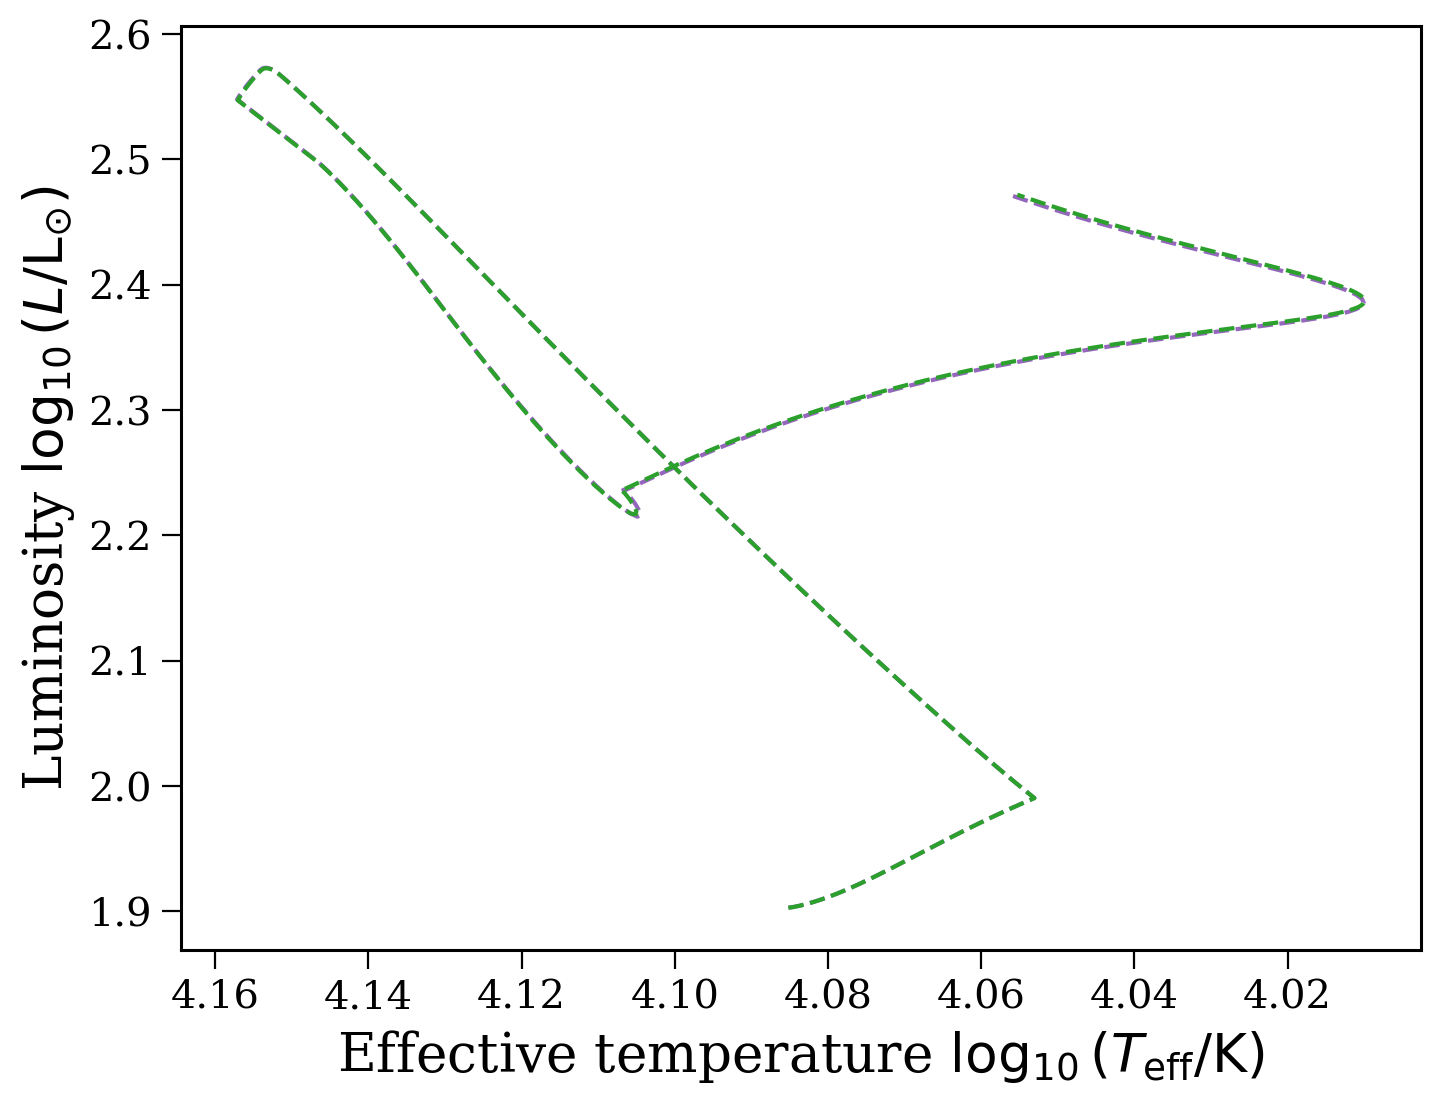

In [38]:
fig, ax = None, None
fig, ax = mpt.simple_hr(tracks["D_20"][1], fig=fig, ax=ax, show=False, s=0, line_colour="tab:purple", linestyle="--", cbar_var=None)
fig, ax = mpt.simple_hr(tracks["convergence-mesh_0.2-time_0.5"][1], fig=fig, ax=ax, show=False, s=0, line_colour="tab:green", linestyle="--", cbar_var=None)
plt.show()

100%|██████████| 1219/1219 [00:28<00:00, 43.26it/s]
/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/profiles.py:119: UserWarning: The figure layout has changed to tight
  


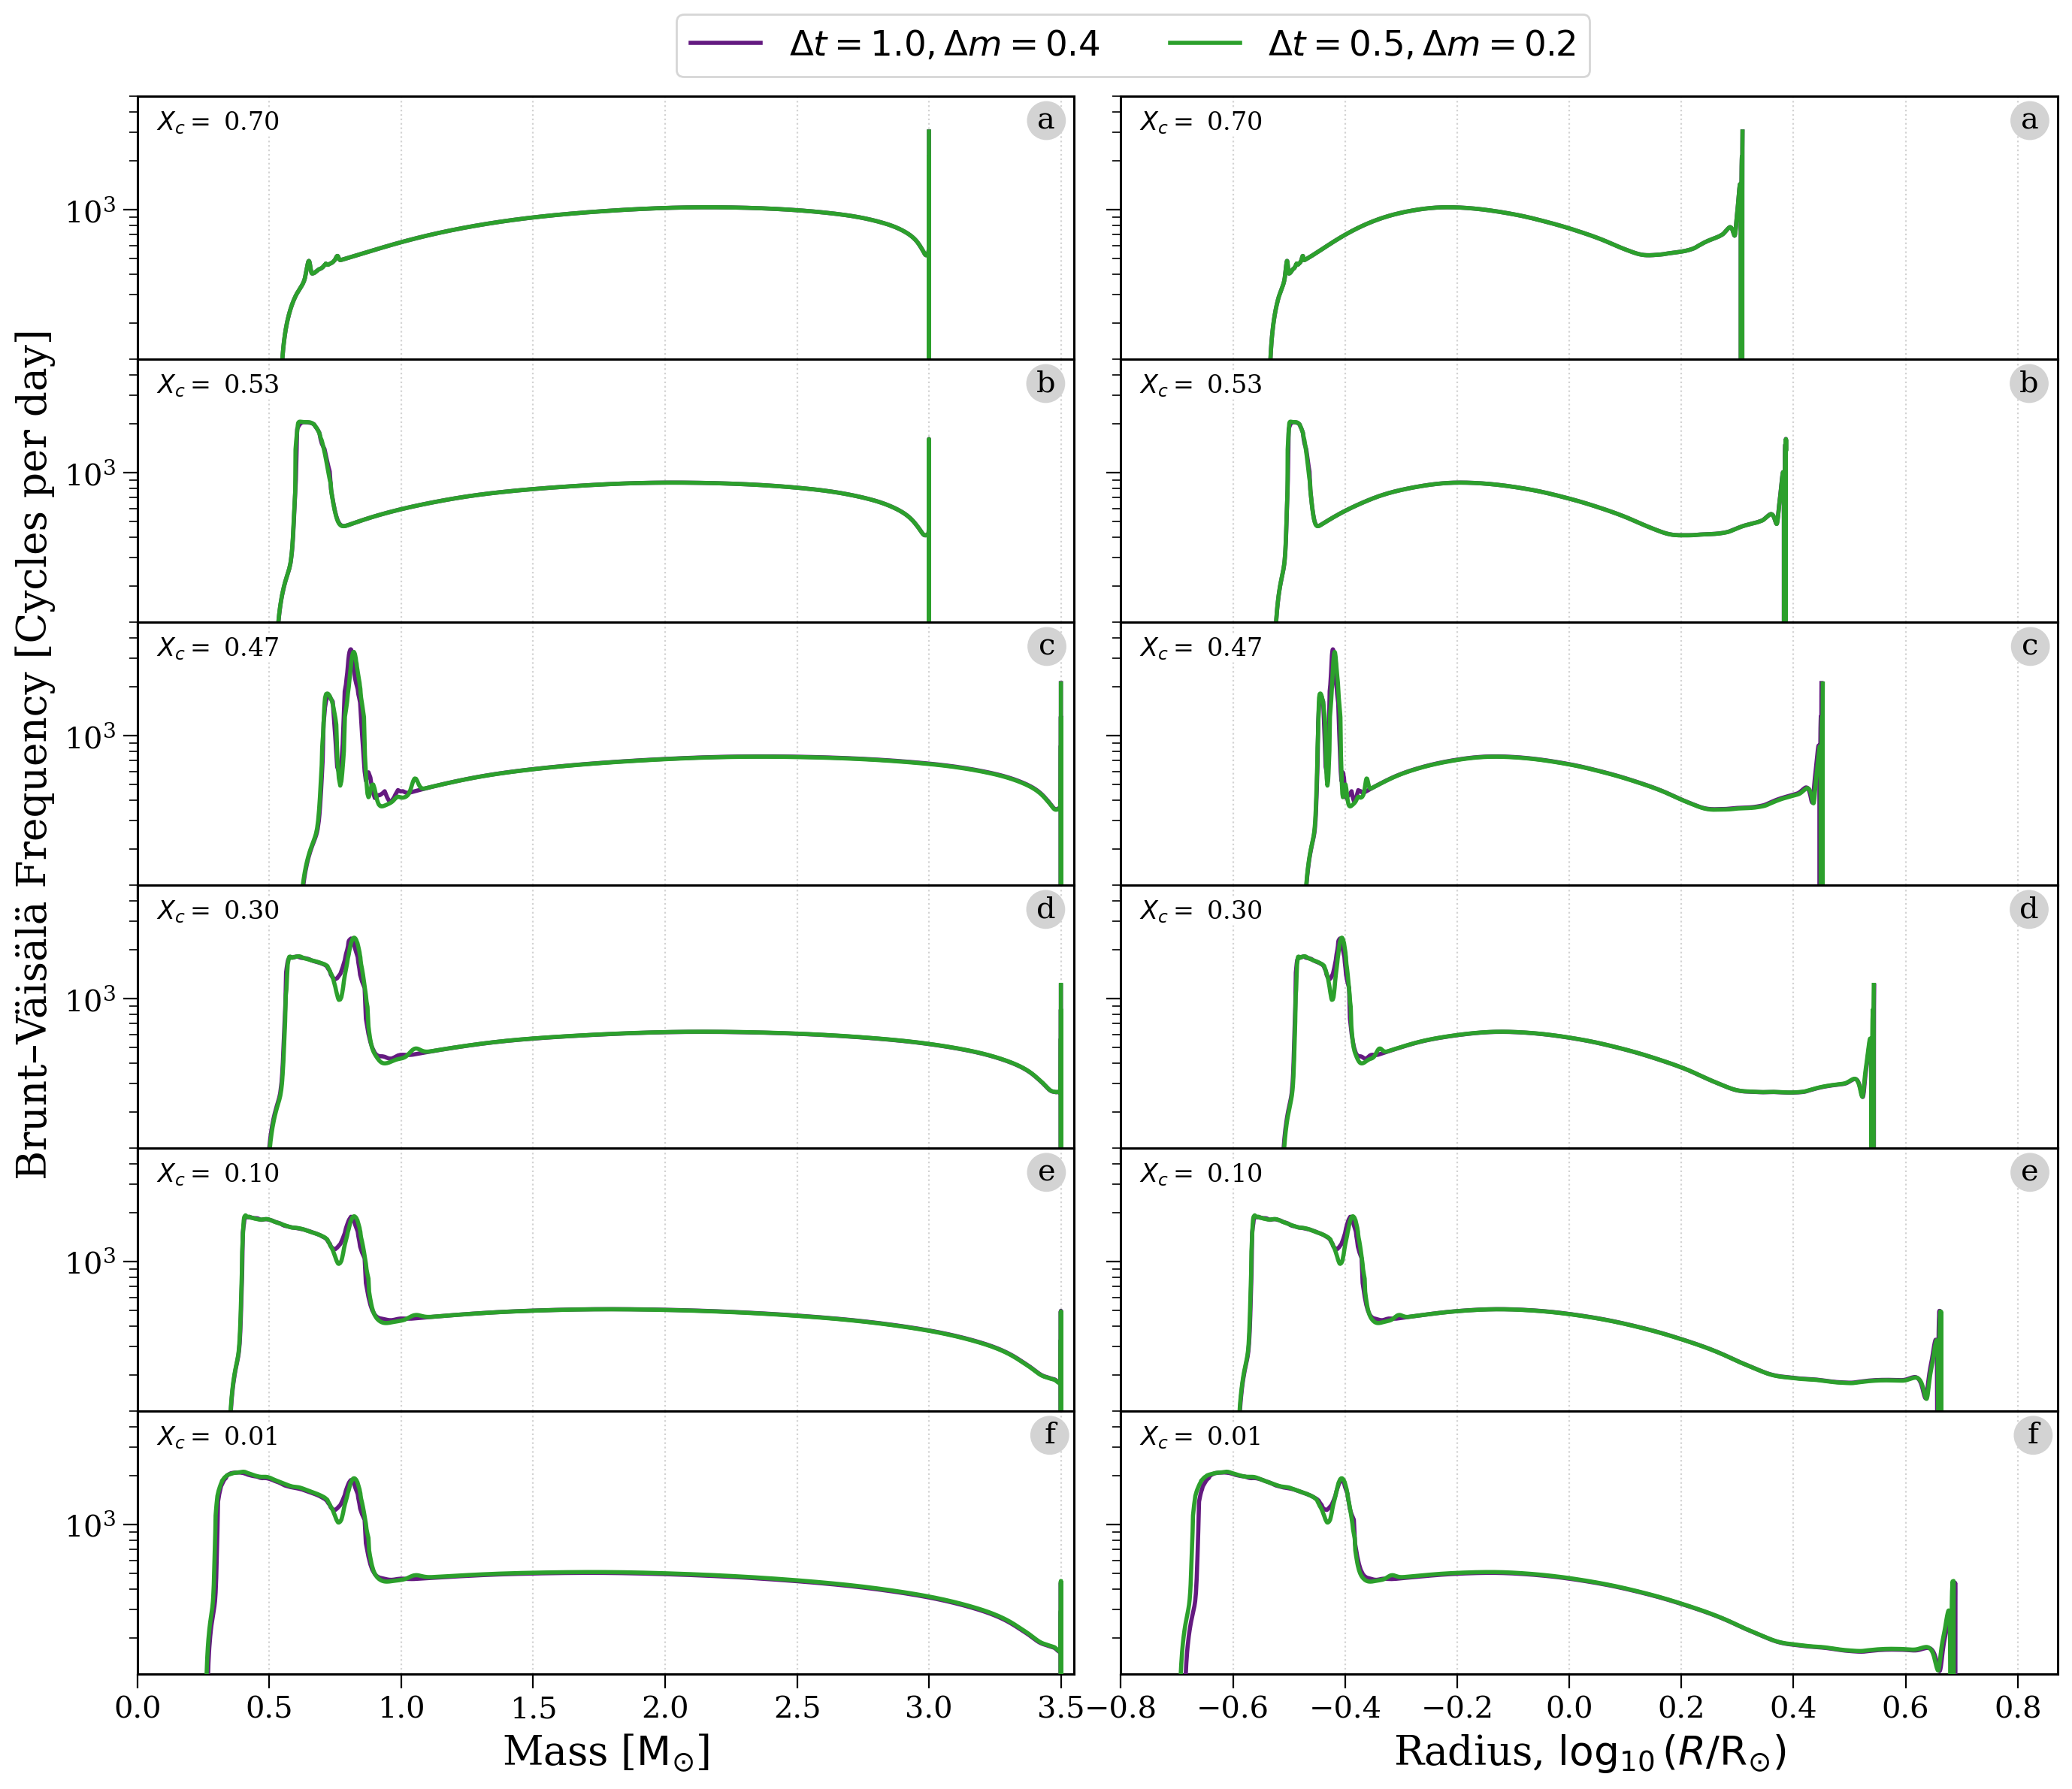

In [39]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 2, figsize=(14, 12), sharex='col', sharey=True)
for X_c, ax in zip(X_c_panels, axes[:, 0]):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], tracks["convergence-mesh_0.2-time_0.5"][1]],
                         fig=fig, ax=ax, show=False, label_with="an", colours=[mpt.mass_gainer_col, "tab:green"],
                         labels=[r"$\Delta t = 1.0, \Delta m = 0.4$", r"$\Delta t = 0.5, \Delta m = 0.2$"], fill=False, lw=2)
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for X_c, ax in zip(X_c_panels, axes[:, 1]):
    mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["D_20"][1], tracks["convergence-mesh_0.2-time_0.5"][1]],
                         fig=fig, ax=ax, show=False, label_with="an", log_radius=True, colours=[mpt.mass_gainer_col, "tab:green"],
                         labels=[r"$\Delta t = 1.0, \Delta m = 0.4$", r"$\Delta t = 0.5, \Delta m = 0.2$"], fill=False, lw=2)
    ax.grid(axis="x", linestyle="dotted", color="lightgrey")

for ax, letter in zip(axes[:, 0], "abcdef"):
    if ax != axes[-1, 0]:
        ax.set_xlabel("")
    ax.set_ylabel("Brunt–Väisälä Frequency [Cycles per day]" if ax == axes[2, 0] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_xlim(0.0, 3.55)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

for ax, letter in zip(axes[:, 1], "abcdef"):
    if ax != axes[-1, 1]:
        ax.set_xlabel("")
    ax.set_ylabel("")
    ax.get_legend().remove()
    ax.set_xlim(left=-0.8)
    ax.set_ylim(1.2e2, 5e3)

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))


fig.legend(*ax.get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.7*fs, ncol=2)

fig.subplots_adjust(hspace=0.0, wspace=0.05, top=0.945)
# plt.savefig("../paper/figures/BV_profile_all_combo.pdf")
plt.show()

## Period spacing

In [ ]:
## ln -sfn mesasdk-x86_64-linux-22.6.1/mesasdk mesasdk
## ln -sfn mesasdk-x86_64-linux-23.7.3/mesasdk mesasdk

In [31]:
mpt.create_GYRE_bash(track=tracks["D_20"][1], X_c=[0.69905, 0.69, 0.6, 0.53, 0.47, 0.4, 0.3, 0.2, 0.1, 0.01], change_folders=True)

cd ../output/binaries/D_20/LOGS_star2; echo -n 'profile1.data.GYRE,profile33.data.GYRE,profile67.data.GYRE,profile102.data.GYRE,profile953.data.GYRE,profile964.data.GYRE,profile980.data.GYRE,profile997.data.GYRE,profile1015.data.GYRE,profile1032.data.GYRE' | xargs -d ',' -P 6 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e; cd -;


In [37]:
mpt.create_GYRE_bash(track=tracks["convergence-mesh_0.2-time_0.5"][1], X_c=[0.69905, 0.69, 0.6, 0.53, 0.47, 0.4, 0.3, 0.2, 0.1, 0.01], change_folders=True)

cd ../output/binaries/convergence-mesh_0.2-time_0.5/LOGS_star2; echo -n 'profile1.data.GYRE,profile33.data.GYRE,profile75.data.GYRE,profile120.data.GYRE,profile1079.data.GYRE,profile1093.data.GYRE,profile1112.data.GYRE,profile1132.data.GYRE,profile1151.data.GYRE,profile1185.data.GYRE' | xargs -d ',' -P 6 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e; cd -;


In [32]:
mpt.create_GYRE_bash(track=singles["D_20"]["M_3.5"], X_c=[0.69905, 0.69, 0.6, 0.53, 0.47, 0.4, 0.3, 0.2, 0.1, 0.01], change_folders=True)

cd ../output/singles/D_20/M_3.5/LOGS; echo -n 'profile6.data.GYRE,profile29.data.GYRE,profile48.data.GYRE,profile58.data.GYRE,profile66.data.GYRE,profile76.data.GYRE,profile92.data.GYRE,profile109.data.GYRE,profile127.data.GYRE,profile144.data.GYRE' | xargs -d ',' -P 6 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e; cd -;


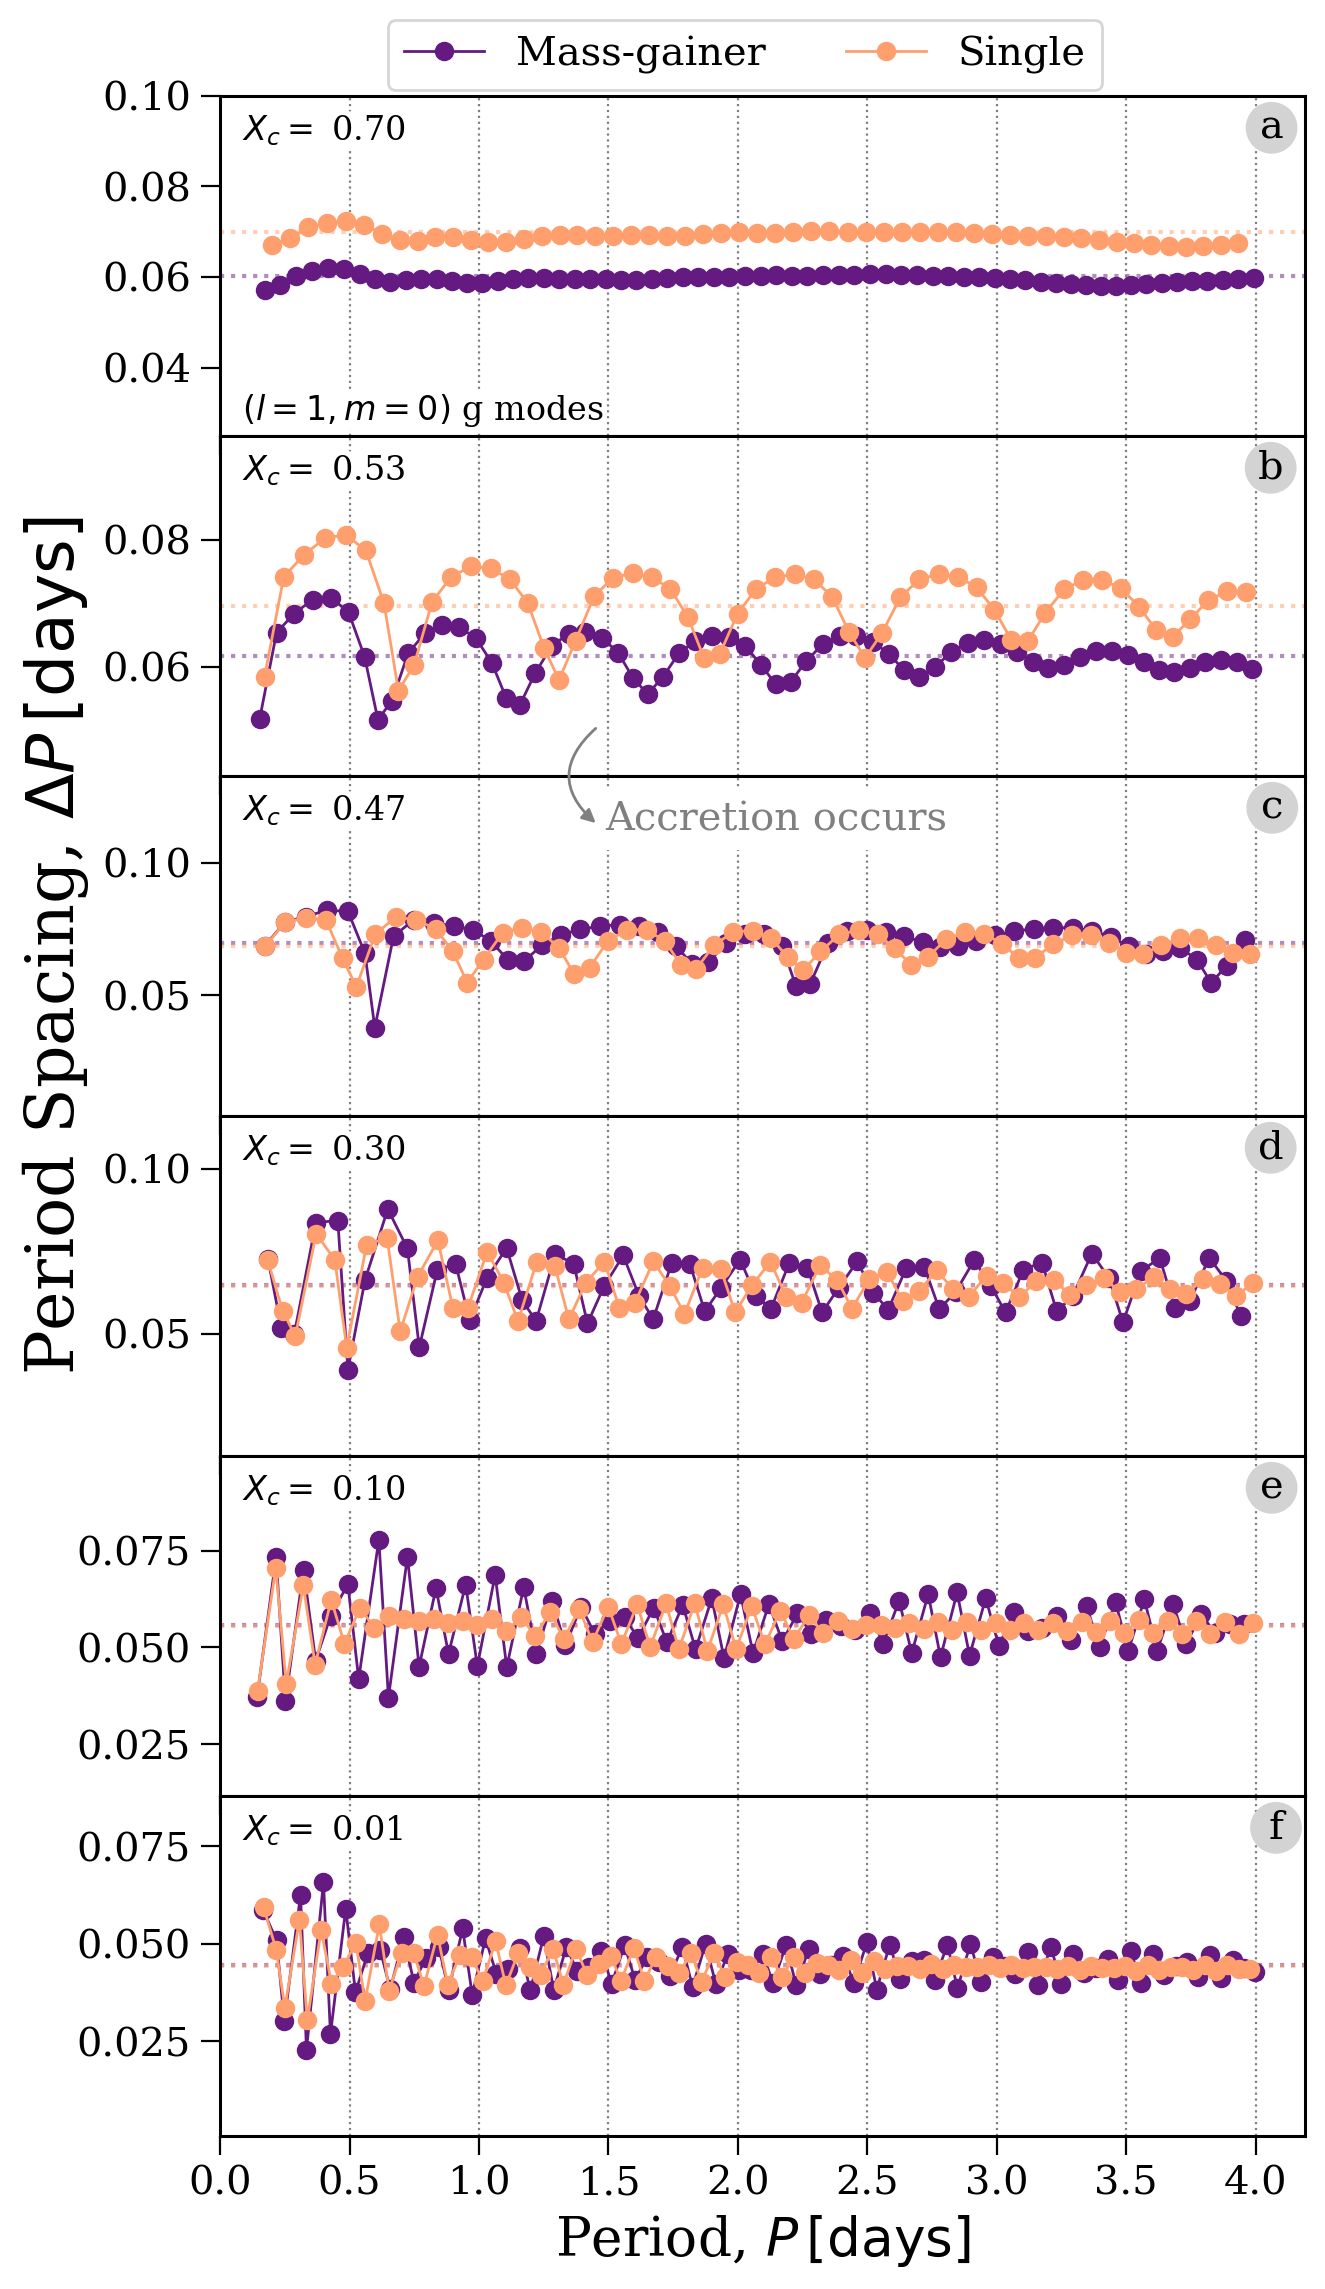

In [43]:
refresh_mpt()
fig, axes = plt.subplots(6, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                            legend_loc="lower right", label_modes=False, mode_type=ax==axes[0],
                            fig=fig, ax=ax, show=False, divide_delta_n=False, ylims="auto")
    
for ax, letter in zip(axes, "abcdef"):
    ax.grid(axis='x', linestyle="dotted", color="grey")
    ax.set_xlim(left=0.0)
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.set_ylabel(r"Period Spacing, $\Delta P \, [\rm days]$", fontsize=fs)
    else:
        ax.set_ylabel("")

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0))

axes[0].set_ylim(0.025, 0.1)


accretion_an_x = 0.35
axes[2].annotate("", xytext=(accretion_an_x, 1.15), xy=(accretion_an_x, 0.85), xycoords="axes fraction",
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=40, angleB=-40", lw=1, color='grey'),
                 zorder=100)
axes[2].annotate("Accretion occurs", xy=(accretion_an_x + 0.005, 0.84), xycoords="axes fraction", ha="left",
                 bbox=dict(boxstyle="round", ec='none', fc='white'), color="grey", fontsize=0.6*fs)

fig.subplots_adjust(hspace=0.0, top=0.96)

plt.savefig("../paper/figures/period_spacing_mdm20.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Appendix: `min_D_mix`

Here we explore how changing `min_D_mix` affects our results

## Brunt-Vaisala Comparison

Parsing min_D_mix = 1 (Accretor)


100%|██████████| 1045/1045 [00:13<00:00, 76.73it/s]


Parsing min_D_mix = 10 (Accretor)


100%|██████████| 1045/1045 [00:13<00:00, 80.33it/s]


Parsing min_D_mix = 50 (Accretor)


100%|██████████| 1049/1049 [00:14<00:00, 70.85it/s] 


Parsing min_D_mix = 100 (Accretor)


100%|██████████| 1047/1047 [00:11<00:00, 87.68it/s]
/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/profiles.py:119: UserWarning: The figure layout has changed to tight
  


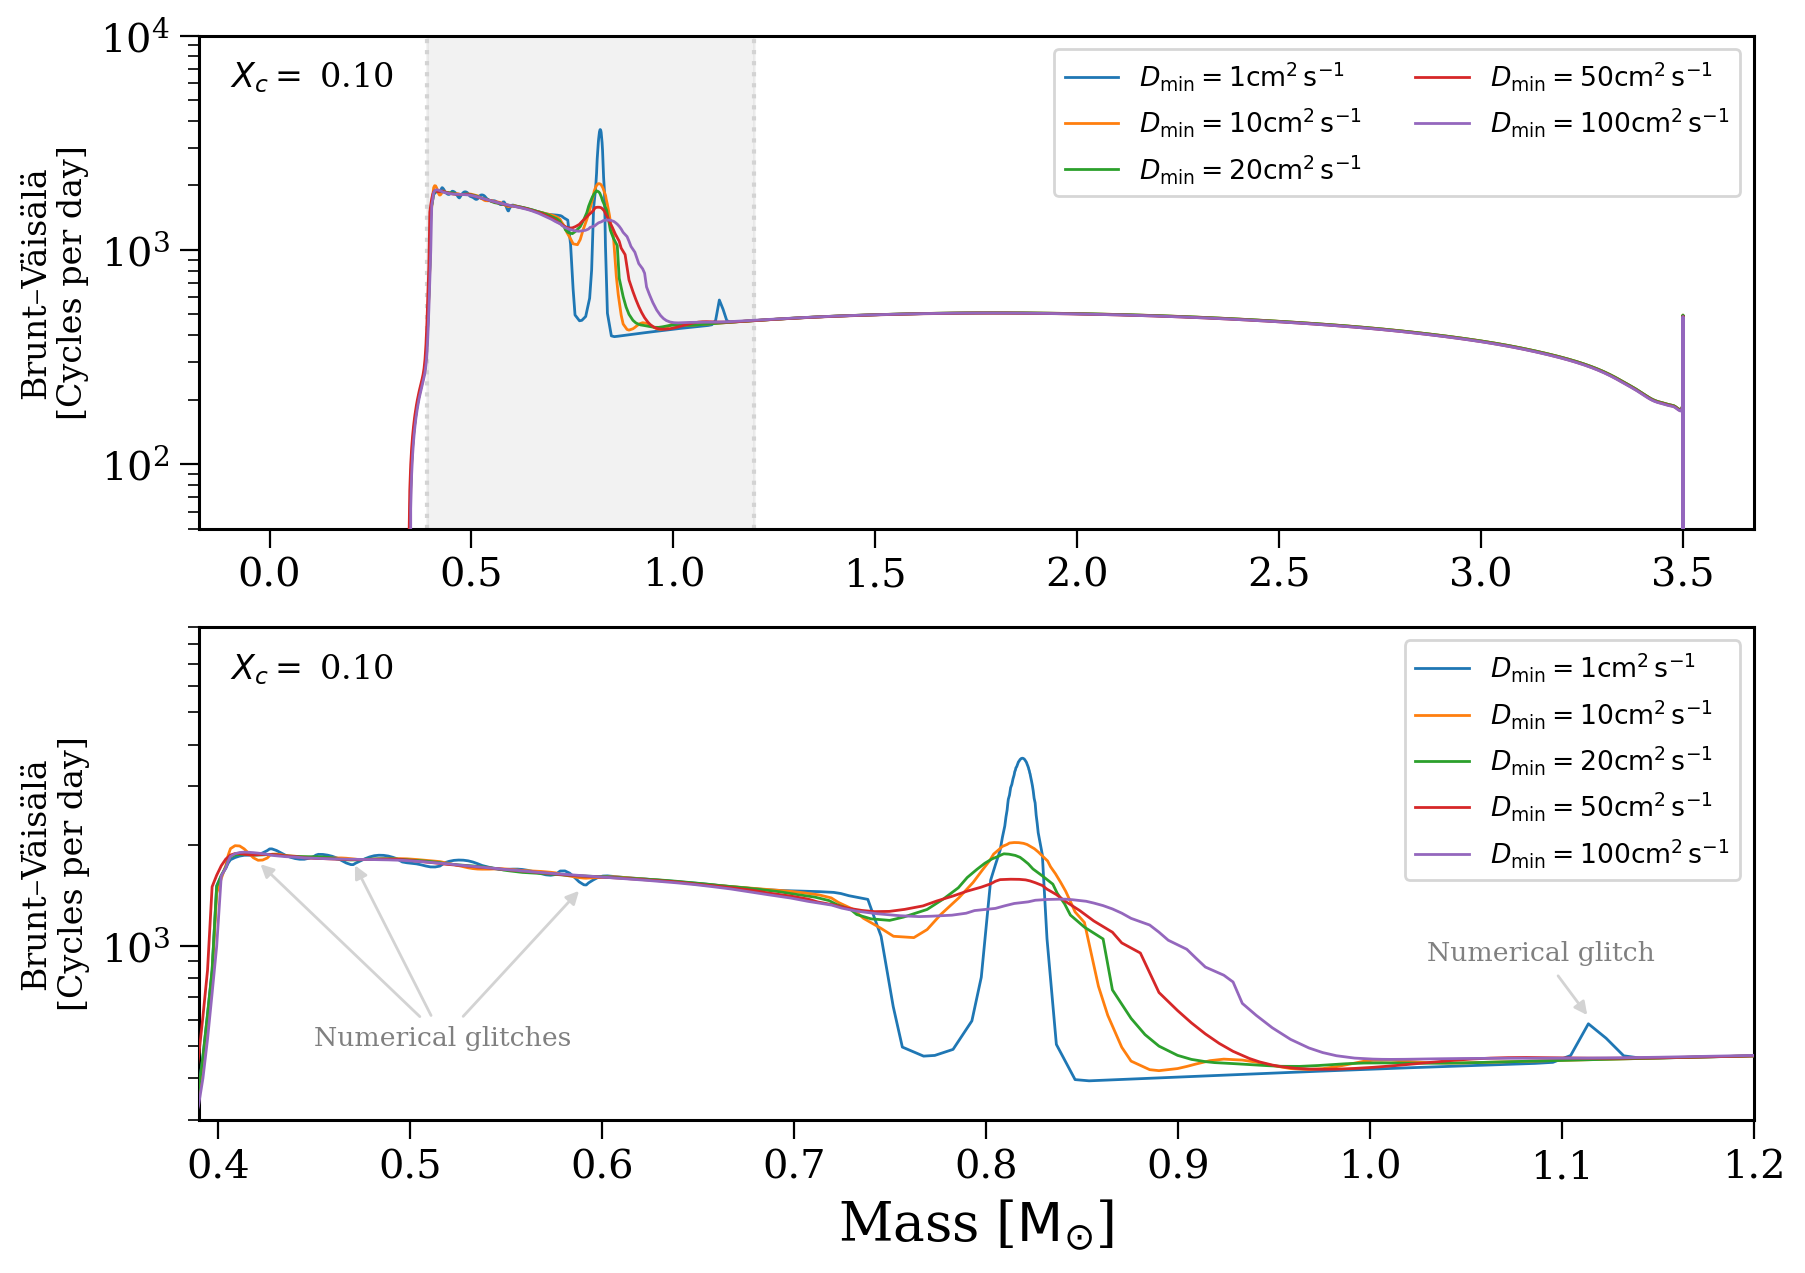

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6.5))

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["D_100"][1], tracks["D_50"][1],
                                                    tracks["D_20"][1],
                                                    tracks["D_10"][1], tracks["D_1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[0])

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["D_100"][1], tracks["D_50"][1],
                                                    tracks["D_20"][1],
                                                    tracks["D_10"][1], tracks["D_1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[1], legend_loc="upper right")

ax.get_legend().remove()
ax.legend(ncol=1, fontsize=0.4*fs)

fig.subplots_adjust(hspace=0.2)

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

axes[1].set_xlim(0.39, 1.2)
axes[1].set_ylim(bottom=3e2, top=9e3)

def add_arrow(ax, text, start, end, hide_text=False):
    ax.annotate(text, xytext=start, xy=end,
                 arrowprops=dict(arrowstyle="-|>", color="lightgrey"),
                 color="grey" if not hide_text else "white", zorder=10, fontsize=0.4*fs)

add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.47, 1.8e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.59, 1.5e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.42, 1.8e3))


add_arrow(axes[1], "Numerical glitch", (1.03, 9e2), (1.115, 6e2))

# plt.savefig("../paper/figures/min_D_mix_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Period spacing pattern

In [38]:
mpt.create_GYRE_bash(track=tracks["D_100"][1], X_c=X_c_panels, change_folders=True)

cd ../output/binaries/D_100/LOGS_star2; echo -n 'profile1.data.GYRE,profile931.data.GYRE,profile954.data.GYRE,profile980.data.GYRE,profile1016.data.GYRE,profile1034.data.GYRE' | xargs -d ',' -P 6 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e; cd -;


In [37]:
mpt.create_GYRE_bash(track=singles["D_100"]["M_3.5"], X_c=X_c_panels, change_folders=True)

Parsing M_3.5 (D_100)
cd ../output/singles/D_100/M_3.5/LOGS; echo -n 'profile6.data.GYRE,profile58.data.GYRE,profile66.data.GYRE,profile92.data.GYRE,profile127.data.GYRE,profile145.data.GYRE' | xargs -d ',' -P 6 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e; cd -;


In [45]:
tracks["D_100"][1]._freqs = None
singles["D_100"]["M_3.5"]._freqs = None

  0%|          | 0/1047 [00:00<?, ?it/s]

100%|██████████| 1047/1047 [00:00<00:00, 27539.60it/s]


Parsing M_3.5 (D_100)


100%|██████████| 191/191 [00:02<00:00, 76.99it/s]


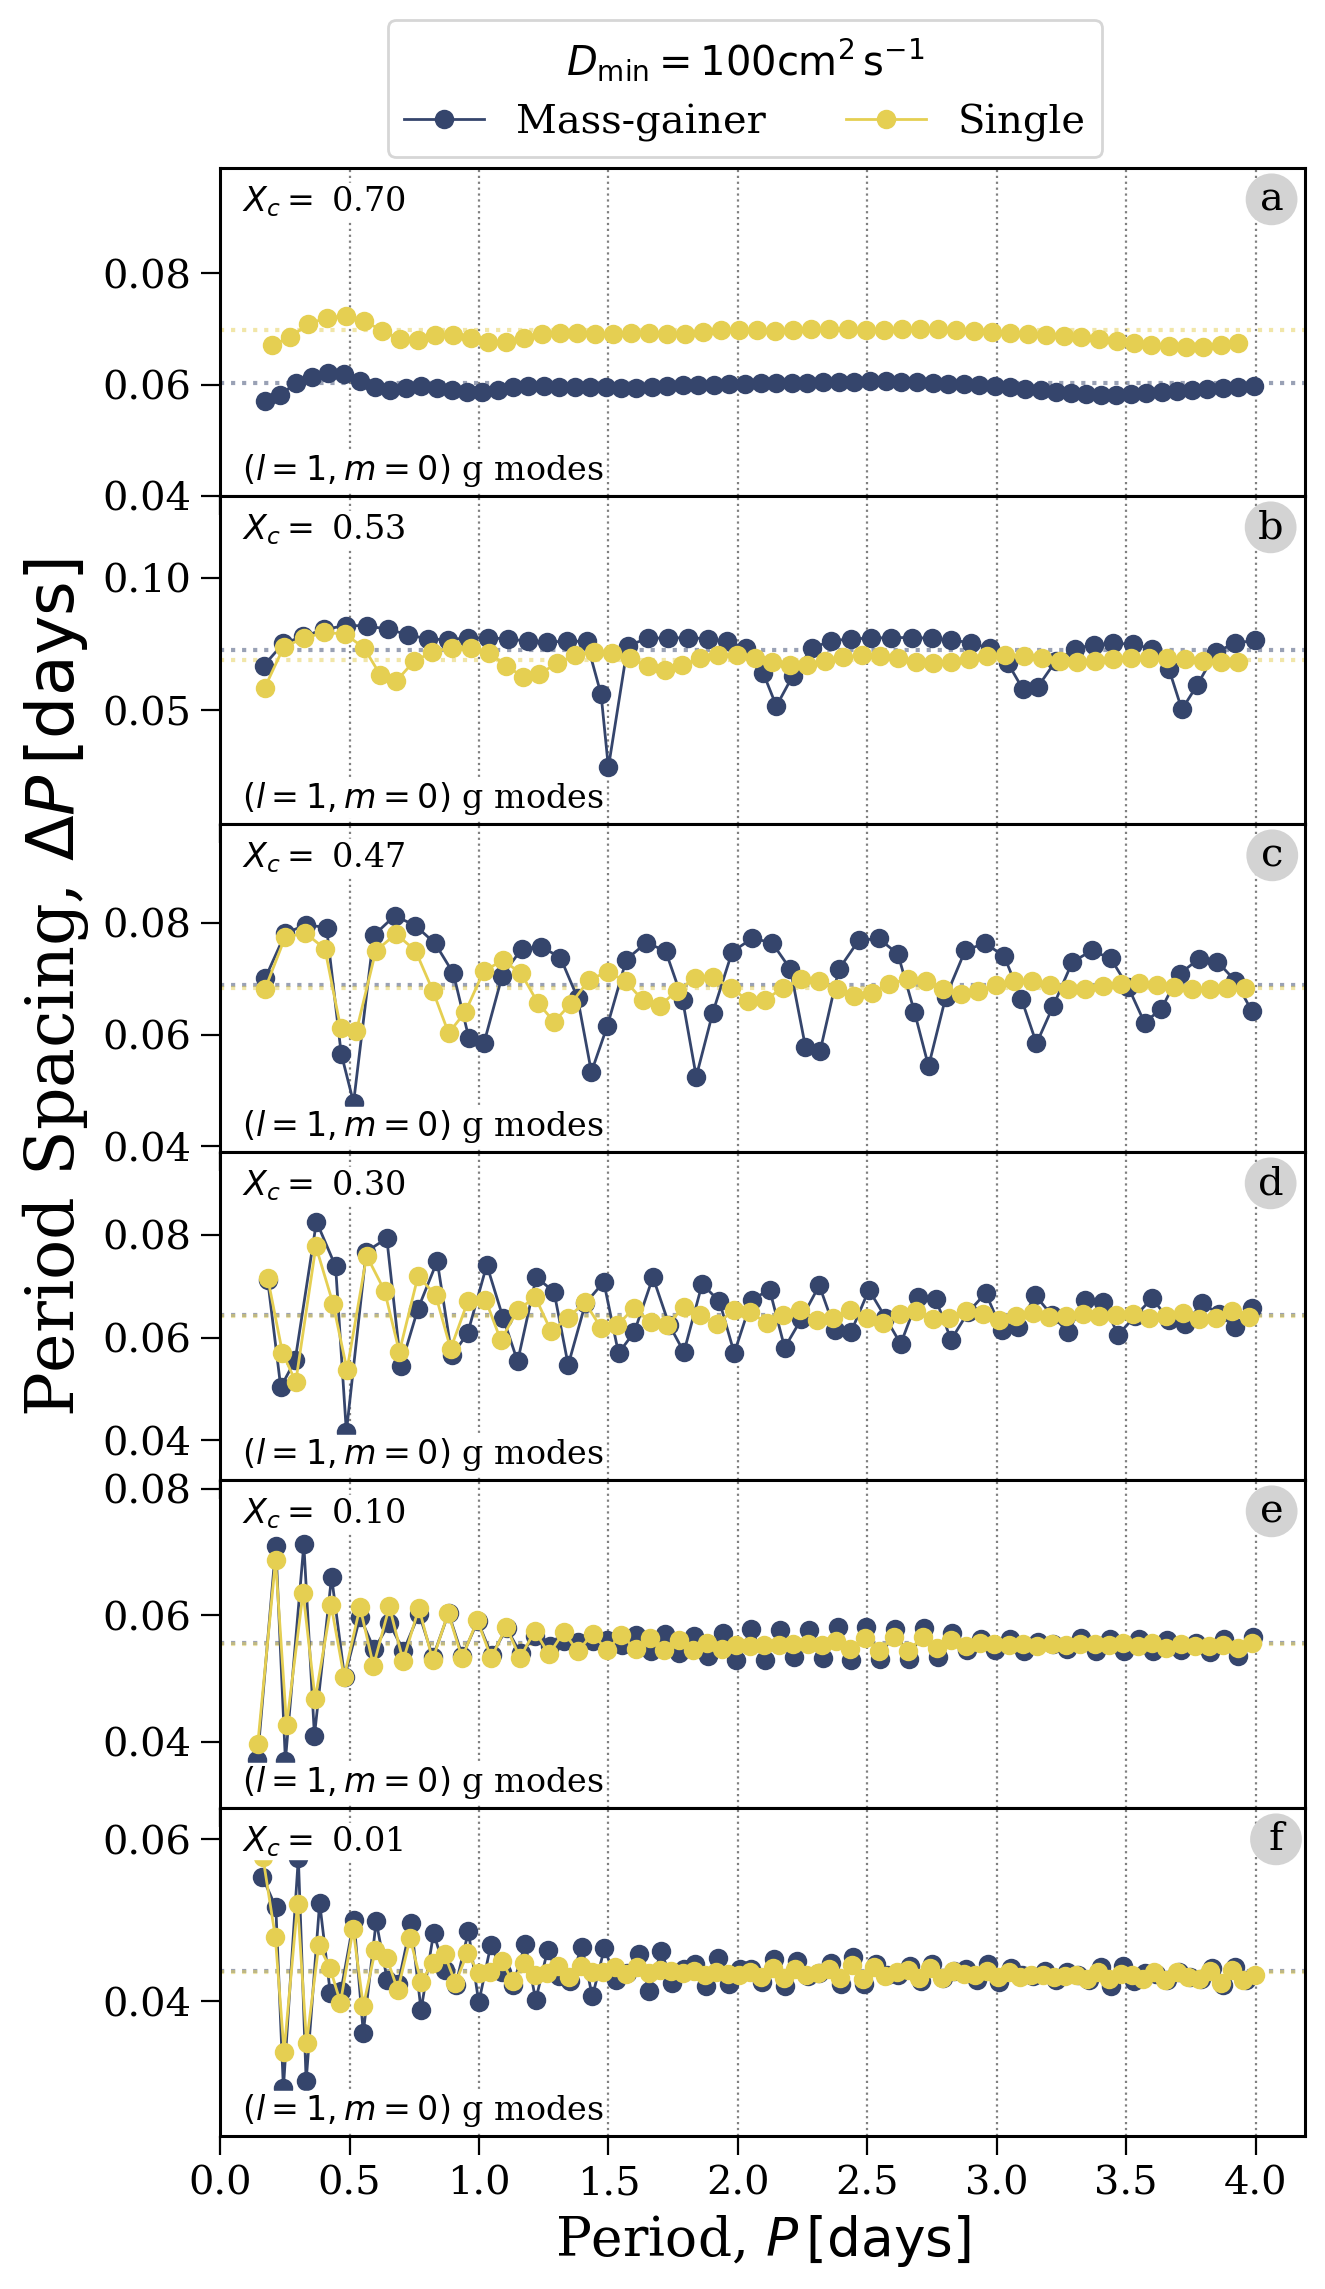

In [47]:
refresh_mpt()
fig, axes = plt.subplots(6, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["D_100"][1], singles["D_100"]["M_3.5"]],
                            colours=[plt.get_cmap("cividis")(0.2), plt.get_cmap("cividis")(0.9)],
                            labels=["Mass-gainer", "Single"],
                            legend_loc="lower right", label_modes=False, fig=fig, ax=ax, show=False,
                            divide_delta_n=True, ylims="auto", ylim_auto_fac=1.4)
    
for ax, letter in zip(axes, "abcdef"):
    ax.grid(axis='x', linestyle="dotted", color="grey")
    ax.set_xlim(left=0.0)
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.set_ylabel(r"Period Spacing, $\Delta P \, [\rm days]$", fontsize=fs)
    else:
        ax.set_ylabel("")

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

axes[0].set_ylim(0.04, 0.099)

leg = fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0),
                 title=r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$")
plt.setp(leg.get_title(),fontsize=0.6*fs)

fig.subplots_adjust(hspace=0.0, top=0.93)

# plt.savefig("../paper/figures/period_spacing_mdm100.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("presentation_plots/period_spacing_mdm100.png", format="png", bbox_inches="tight", dpi=300)

plt.show()

# Appendix: Convergence

/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/profiles.py:53: UserWarning: The figure layout has changed to tight
  


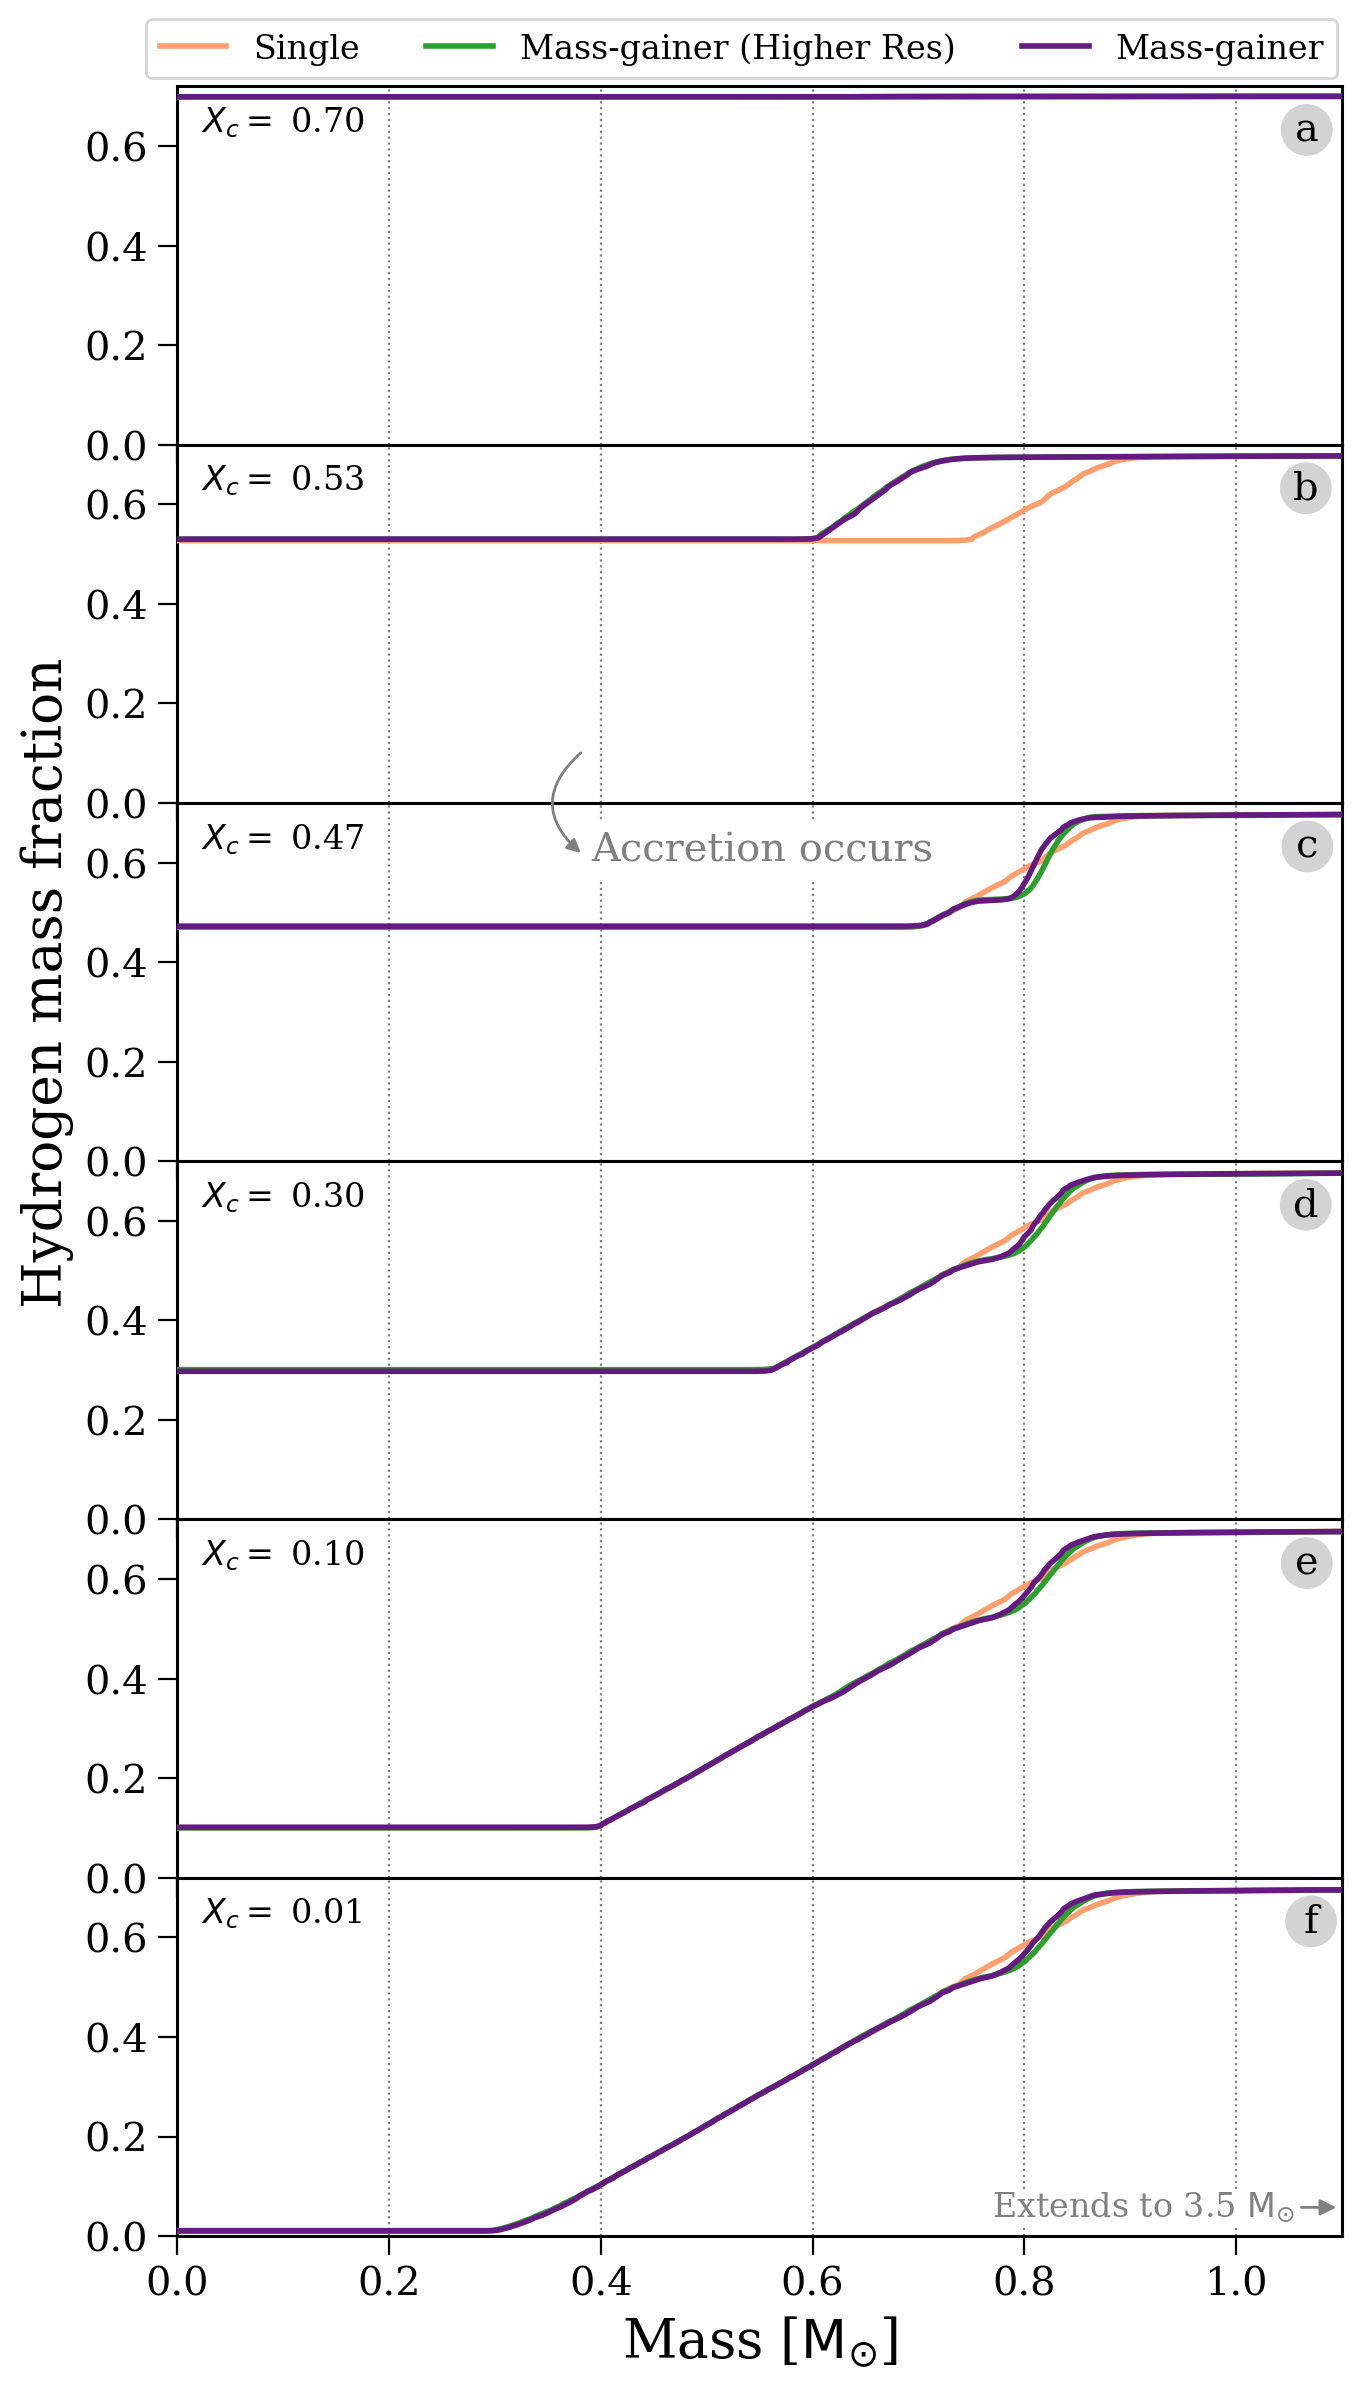

In [51]:
refresh_mpt()
fig, axes = plt.subplots(len(X_c_panels), 1, figsize=(7, 12), sharex=True)
plt.tight_layout()
for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_X_H_profile(X_c=X_c, tracks=[singles["D_20"]["M_3.5"]], labels=["Single"],
                         fig=fig, ax=ax, show=False, label_with="an", annotate_col="grey")
    mpt.plot_X_H_profile(X_c=X_c, tracks=[tracks["convergence-mesh_0.2-time_0.5"][1], tracks["D_20"][1]],
                         fig=fig, ax=ax, show=False, label_with="an", annotate_col="grey",
                         colours=["tab:green", mpt.mass_gainer_col], labels=["Mass-gainer (Higher Res)", "Mass-gainer"])
    ax.grid(axis="x", linestyle="dotted", color="grey")

for ax, letter in zip(axes, "abcdef"):
    if ax != axes[-1]:
        ax.set_xlabel("")
    ax.set_ylabel("Hydrogen mass fraction" if ax == axes[2] else "", fontsize=0.8*fs)
    ax.get_legend().remove()
    ax.set_ylim(top=0.72)

    ax.annotate(letter, xy=(0.98, 0.93), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

accretion_an_x = 0.35
axes[2].annotate("", xytext=(accretion_an_x, 1.15), xy=(accretion_an_x, 0.85), xycoords="axes fraction",
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=40, angleB=-40", lw=1, color='grey'),
                 zorder=100)
axes[2].annotate("Accretion occurs", xy=(accretion_an_x + 0.005, 0.84), xycoords="axes fraction", ha="left",
                 bbox=dict(boxstyle="round", ec='none', fc='white'), color="grey", fontsize=0.6*fs)


ax.annotate(f"Extends to {3.5:1.1f} " + r"$\rm M_{\odot}$", xy=(1, 0.08), xytext=(0.96, 0.08),
            xycoords="axes fraction", ha="right", va="center", color="grey",
            arrowprops=dict(arrowstyle="-|>", color="grey"), fontsize=0.5*fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", pad=0))

fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.55, 1, 0, 0),
           fontsize=0.5*fs, ncol=3)

fig.subplots_adjust(hspace=0.0, top=0.965)
plt.savefig("../paper/figures/XH_profiles_convergence.pdf")
plt.show()

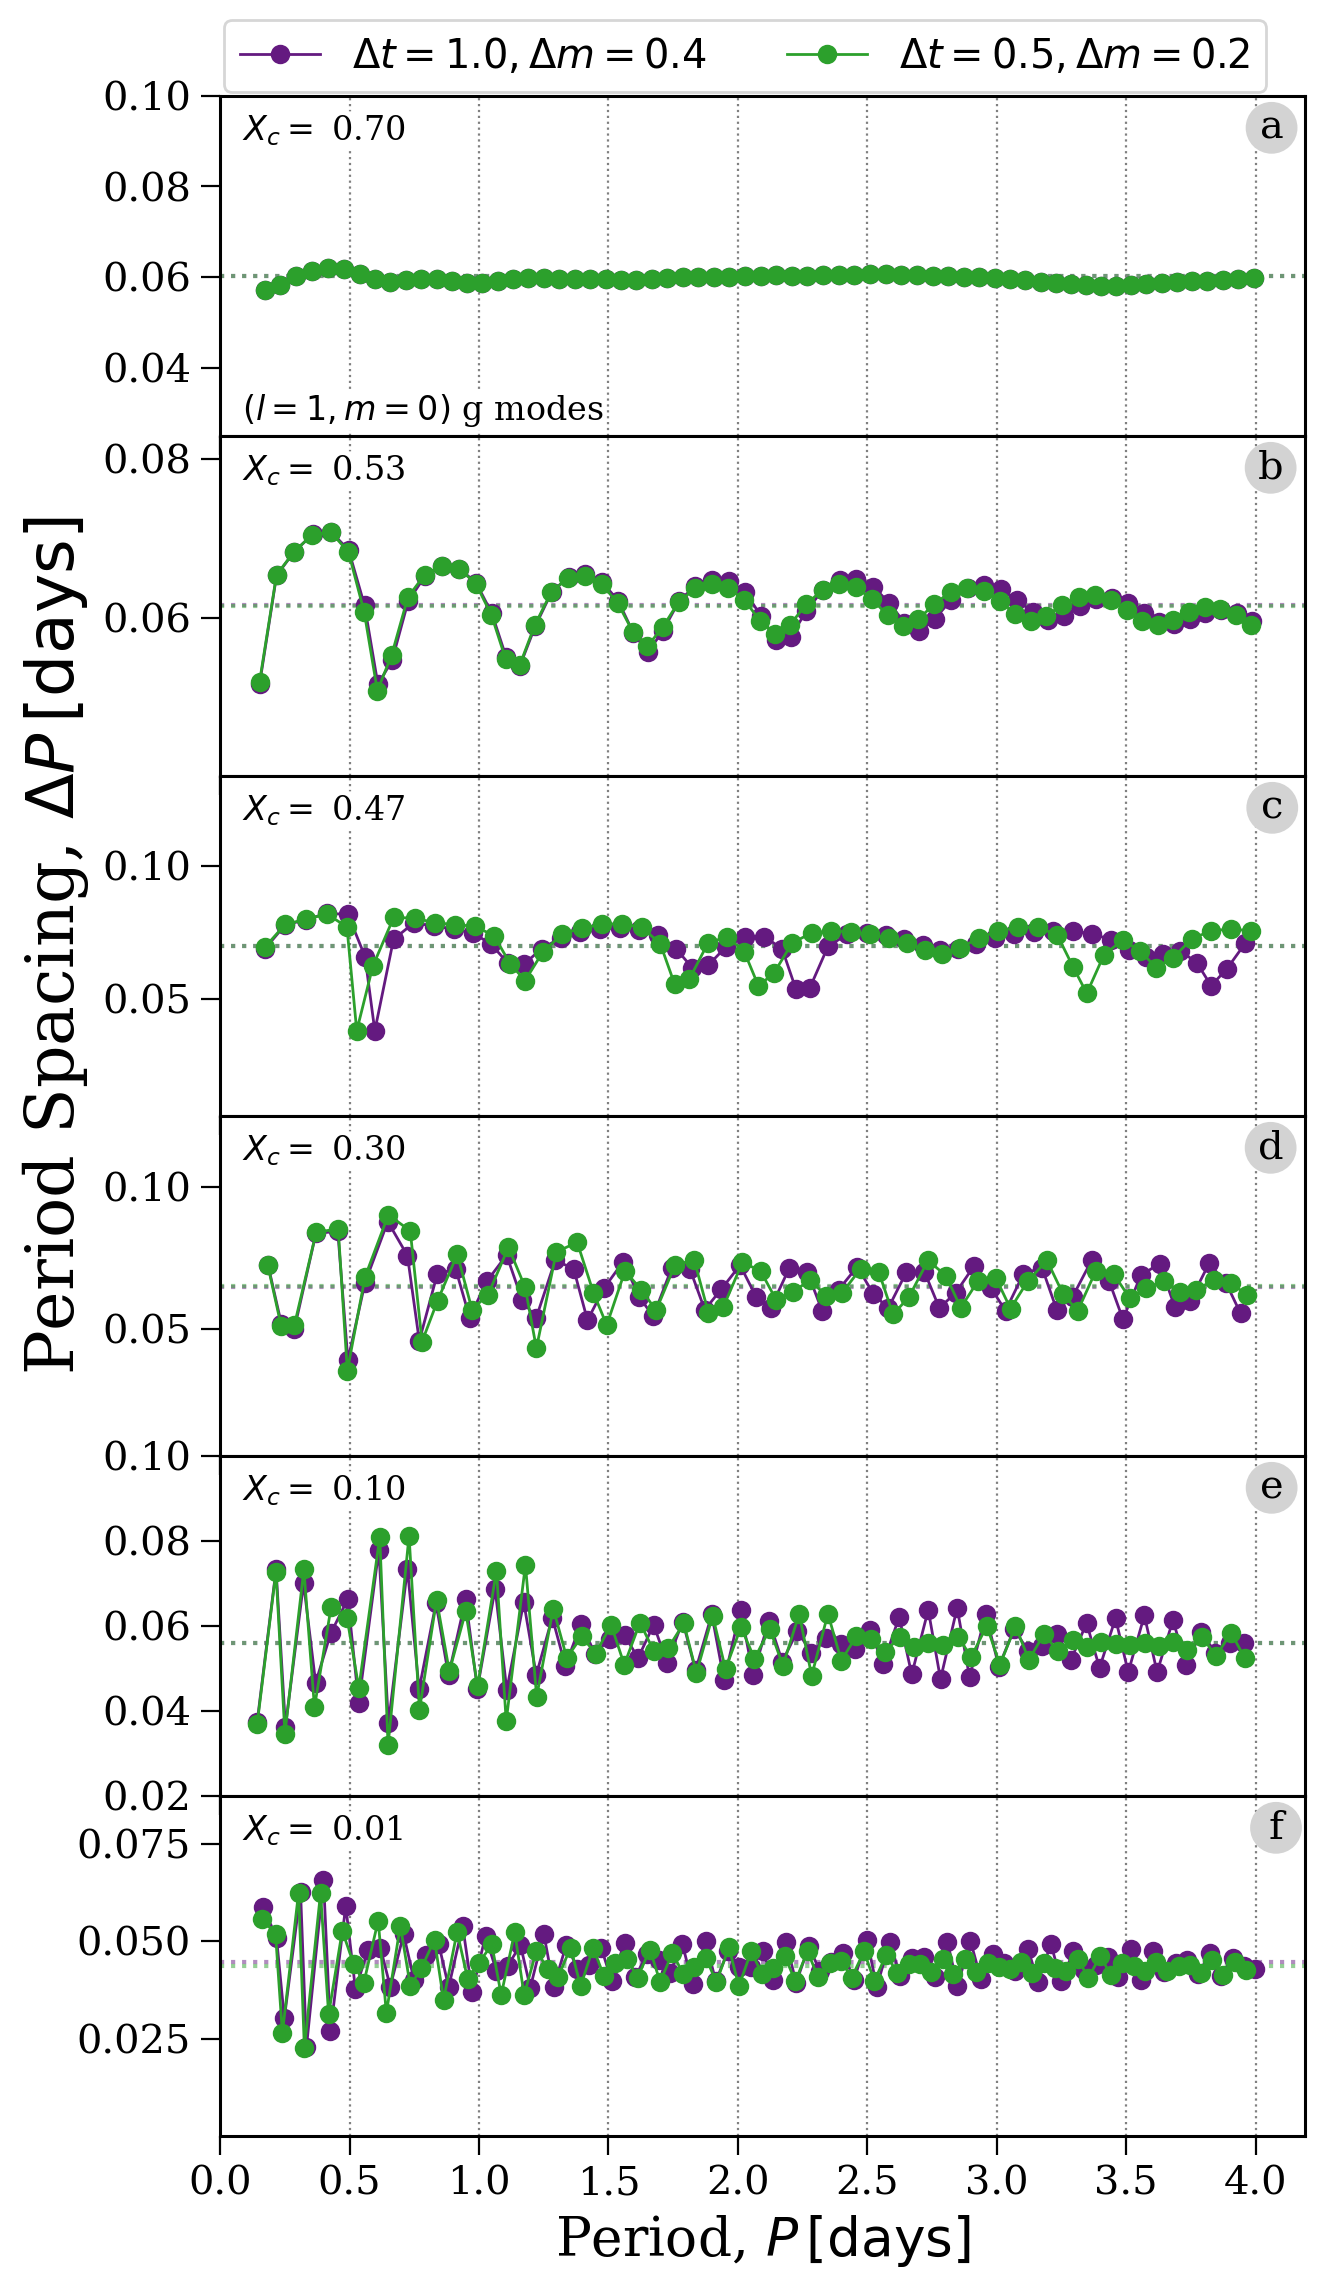

In [81]:
refresh_mpt()
fig, axes = plt.subplots(6, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["D_20"][1], tracks["convergence-mesh_0.2-time_0.5"][1]],
                            legend_loc="lower right", label_modes=False, mode_type=ax==axes[0],
                            fig=fig, ax=ax, show=False, divide_delta_n=False, ylims="auto", colours=[mpt.mass_gainer_col, "tab:green"],
                         labels=[r"$\Delta t = 1.0, \Delta m = 0.4$", r"$\Delta t = 0.5, \Delta m = 0.2$"])
    
for ax, letter in zip(axes, "abcdef"):
    ax.grid(axis='x', linestyle="dotted", color="grey")
    ax.set_xlim(left=0.0)
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.set_ylabel(r"Period Spacing, $\Delta P \, [\rm days]$", fontsize=fs)
    else:
        ax.set_ylabel("")

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0))

axes[0].set_ylim(0.025, 0.1)
axes[4].set_ylim(0.02, 0.1)

fig.subplots_adjust(hspace=0.0, top=0.96)

plt.savefig("../paper/figures/period_spacing_convergence.pdf", format="pdf", bbox_inches="tight")

plt.show()

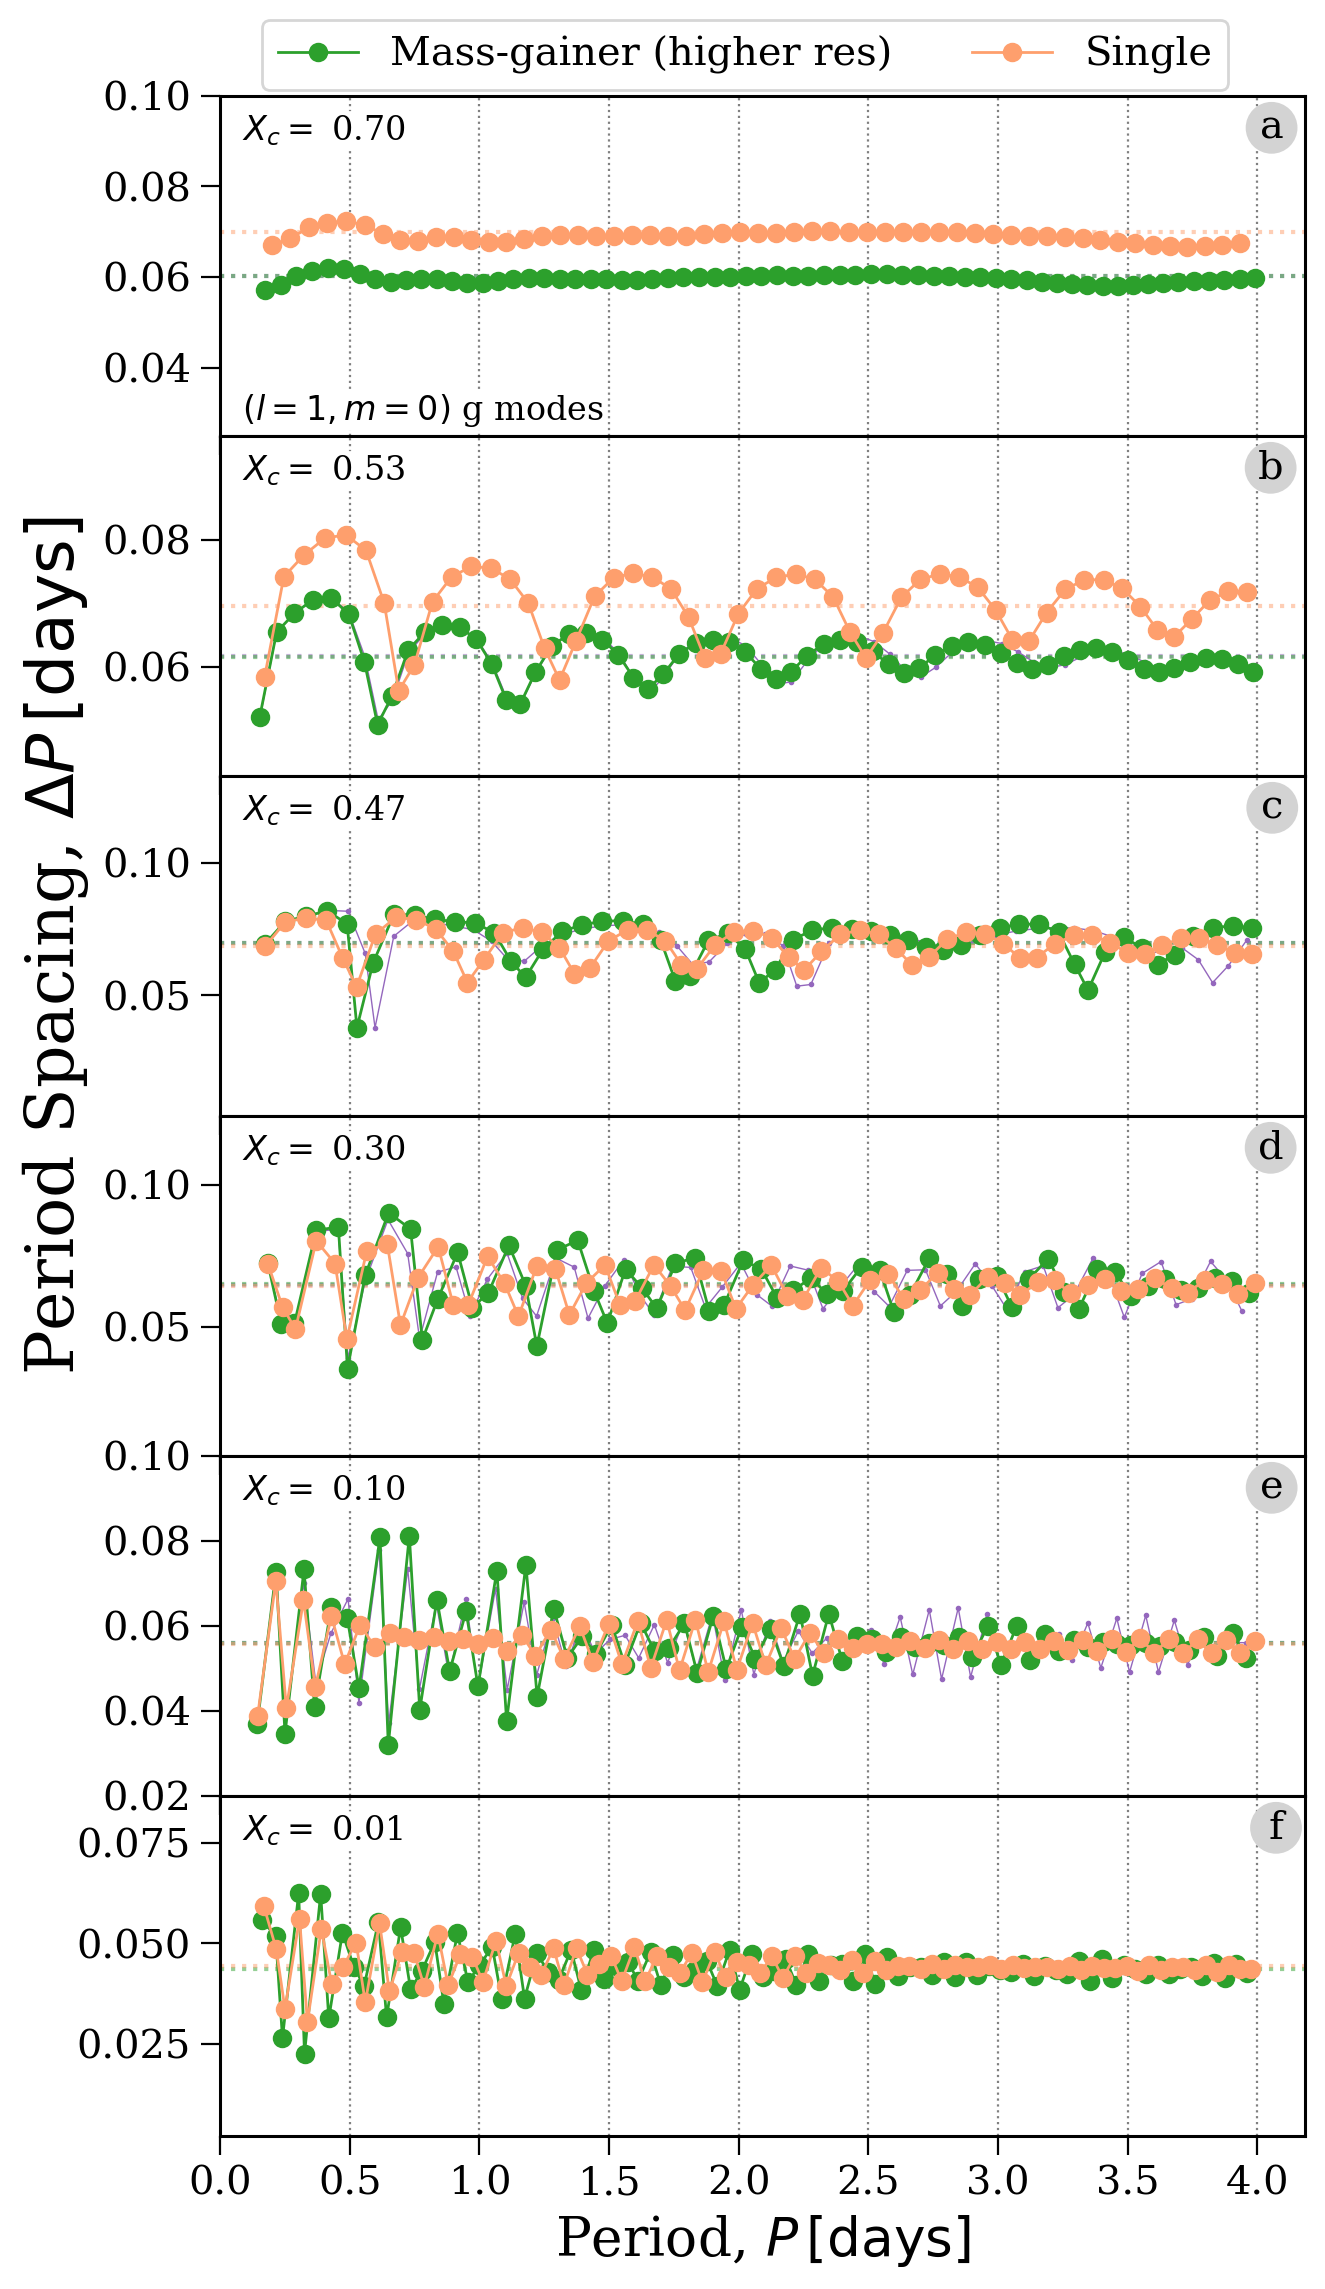

In [82]:
refresh_mpt()
fig, axes = plt.subplots(6, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip(X_c_panels, axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["D_20"][1]],
                            legend_loc="lower right", label_modes=False, mode_type=ax==axes[0],
                            fig=fig, ax=ax, show=False, divide_delta_n=False, ylims="auto", markersize=1, linewidth=0.5, colours=["tab:purple"])
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["convergence-mesh_0.2-time_0.5"][1], singles["D_20"]["M_3.5"]],
                            legend_loc="lower right", label_modes=False, mode_type=ax==axes[0],
                            fig=fig, ax=ax, show=False, divide_delta_n=False, ylims="auto",
                            colours=["tab:green", mpt.single_col], labels=["Mass-gainer (higher res)", "Single"])
    
for ax, letter in zip(axes, "abcdef"):
    ax.grid(axis='x', linestyle="dotted", color="grey")
    ax.set_xlim(left=0.0)
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.set_ylabel(r"Period Spacing, $\Delta P \, [\rm days]$", fontsize=fs)
    else:
        ax.set_ylabel("")

    ax.annotate(letter, xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs,
                bbox=dict(boxstyle="circle", fc="lightgrey", ec="lightgrey", pad=0.15))

fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0))

axes[0].set_ylim(0.025, 0.1)
axes[4].set_ylim(0.02, 0.1)

fig.subplots_adjust(hspace=0.0, top=0.96)

plt.savefig("../paper/figures/period_spacing_convergence_alt.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Data for interactive website plots
(This section is just for me to convert the main data to simple files for my website)

In [297]:
import h5py as h5
import astropy.units as u
import pandas as pd

In [248]:
def history_file_to_hrd_h5(file, h5_file, h5_key):
    df = pd.read_csv(file, delim_whitespace=True, skiprows=5)
    df = df.loc[df.center_h1 <= df.center_h1.max() - 0.005]
    df = df[["star_age", "log_L", "log_Teff", "log_abs_mdot"]]
    df["log_abs_mdot"] = df["log_abs_mdot"].apply(lambda x: x if x > -8 else -8)
    df["star_age"] = df["star_age"] / 1e6
    h5_file.create_group(h5_key)
    for key in df.columns:
        h5_file[h5_key][key] = df[key].values

with h5.File("/home/tom/Documents/coding/tomwagg.github.io/html/interact/hrd.h5", "w") as f:
    history_file_to_hrd_h5("../output/binaries/no_detach_history.data", f, "donor_no_detach")
    history_file_to_hrd_h5("../output/binaries/D_20/LOGS_star2/history.data", f, "accretor")
    for M in np.arange(3, 4.1, 0.1).round(1):
        history_file_to_hrd_h5(f"../output/singles/D_20/M_{M}/LOGS/history.data", f, f"single_{M}")

In [296]:
with h5.File("/home/tom/Documents/coding/tomwagg.github.io/html/interact/psp.h5", "w") as f:
    for track, label in zip([tracks["D_20"][1], singles["D_20"]["M_3.5"]], ["mg", "s"]):
        mods = mpt.utils.find_closest_model_number(track, X_c=X_c_panels)
        gg = f.create_group(label)
        for mod, xc in zip(mods, X_c_panels):
            g = gg.create_group(f"xc_{xc}")
            periods, ng, delta_p = mpt.utils.get_delta_p(track=track, mod=mod, drop_duplicate_ng=True)
            aps = mpt.utils.asymptotic_period_spacing(track.profiles[mod - 1]).to(u.day).value
            g["periods"] = periods
            g["delta_p"] = delta_p
            g.attrs["aps"] = aps

In [268]:
time_range = np.concatenate((np.arange(0, 162, 1), np.arange(161.7, 162, 0.01), np.arange(163, 301, 1)))
mass_gainer_models = mpt.find_closest_model_number(tracks["D_20"][1], time_range)
single_models = mpt.find_closest_model_number(singles["D_20"]["M_3.5"], time_range)
mass_gainer_models[mass_gainer_models > 1033] = 1033
single_models[single_models > 145] = 145
# 
with h5.File("/home/tom/Documents/coding/tomwagg.github.io/html/interact/profile_data.h5", "w") as f:
    for t, mg_mod, s_mod in zip(time_range, mass_gainer_models, single_models):
        g = f.create_group(f"t_{t:1.2f}")
        for track, mod, label in zip([tracks["D_20"][1], singles["D_20"]["M_3.5"]],
                                     [mg_mod, s_mod], ["mg", "s"]):
            df = track.profiles[mod][["mass", "x_mass_fraction_H", "brunt_N"]]
            
            g.create_group(label)
            g[label]["mass"] = df["mass"].values
            g[label]["xh"] = df["x_mass_fraction_H"].values
            g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)

/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero encountered in log10
  g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)
/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero encountered in log10
  g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)
/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero encountered in log10
  g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)
/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero encountered in log10
  g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)
/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero encountered in log10
  g[label]["N"] = np.log10(df["brunt_N"].values * ((2 * np.pi * u.Hz).to(u.day**(-1))).value)
/tmp/ipykernel_368208/1105023186.py:18: RuntimeWarning: divide by zero